In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras, time, sys, os, gc

DTYPE_OP = 'float32'
keras.backend.set_floatx(DTYPE_OP)

if DTYPE_OP == 'float64':
    keras.backend.set_epsilon(np.finfo(np.float64).eps)
elif DTYPE_OP == 'float32':
    keras.backend.set_epsilon(np.finfo(np.float32).eps)

In [46]:
#GLOBAL Variables
BATCH_SIZE = 128 #rodrigues = BATCH_SIZE = 64
EPOCHS_BASE = 50
OPT = 'adam' #optimizer for neural network 
TOL = 3e-2

In [47]:
label_names = ...
folder = "./Fashion10000/"

### Load Data and preprocess

In [48]:
X_vgg16 = np.load(folder+"Fashion10000_VGG_avg_all.npy")
X_vgg16.shape

(31077, 512)

In [56]:
Q_s = "Q4" #question selected
p_error = "0.5" #Q3: cerca de 82-84.. valores varian 2% 

In [57]:
sets = np.loadtxt(folder+"sets_"+p_error+"_"+Q_s+".txt", dtype='U')
mask_train = sets == "train"
mask_test = sets == "test"

Z_data = np.loadtxt(folder+"Z_data_"+Q_s+".txt",dtype='int')
Z_train = Z_data[mask_train]
Z_test = Z_data[mask_test]

X_train_vgg16 = X_vgg16[mask_train]
X_test_vgg16 = X_vgg16[mask_test]

X_val_vgg16 = X_test_vgg16
Z_val = Z_test

print("Input train shape:",X_train_vgg16.shape)
print("Label train shape:",Z_train.shape)

print("Input test shape:",X_test_vgg16.shape)
print("Label test shape:",Z_test.shape)

Input train shape: (25915, 512)
Label train shape: (25915,)
Input test shape: (1190, 512)
Label test shape: (1190,)


In [27]:
## create new test...
mask_val = np.random.rand(Z_train.shape[0]) < 0.25 #0.33

mask_test[mask_train] = mask_val #test selected to be test
mask_train[mask_train] = ~mask_val #train extracted to be test..

mask_sets = np.asarray(["aux" for _ in range(Z_data.shape[0])]).astype("U5")
mask_sets[mask_train] = "train"
mask_sets[mask_test] = "test"

y_obs = np.loadtxt(folder+"answers_"+p_error+"_"+Q_s+".txt",dtype='int16')#not annotation symbol ==-1

np.savetxt(folder+"sets_"+p_error+"_"+Q_s+".txt", mask_sets,delimiter=' ', fmt='%s')
np.savetxt(folder+"answers_"+p_error+"_"+Q_s+".txt", y_obs[~mask_val], delimiter=' ', fmt='%d')

KeyboardInterrupt: 

In [7]:
#created before..
mask_val = np.random.rand(Z_train.shape[0]) < 0.33 #0.25 #0.33

In [63]:
X_val_vgg16 = X_train_vgg16[mask_val]
X_train_vgg16 = X_train_vgg16[~mask_val]
Z_val = Z_train[mask_val]
Z_train = Z_train[~mask_val]

X_val_vgg16 = np.concatenate([X_val_vgg16,X_test_vgg16])
Z_val = np.concatenate([Z_val,Z_test])


print("Input train shape:",X_train_vgg16.shape)
print("Label train shape:",Z_train.shape)

print("Input val shape:",X_val_vgg16.shape)
print("Label val shape:",Z_val.shape)

Input train shape: (18201, 512)
Label train shape: (18201,)
Input val shape: (8904, 512)
Label val shape: (8904,)


In [51]:
Xstd_train = X_train_vgg16
Xstd_val = X_val_vgg16
Xstd_test = X_test_vgg16

In [70]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler().fit(X_train_vgg16)
Xstd_train = std.transform(X_train_vgg16)
Xstd_val = std.transform(X_val_vgg16)
Xstd_test = std.transform(X_test_vgg16)

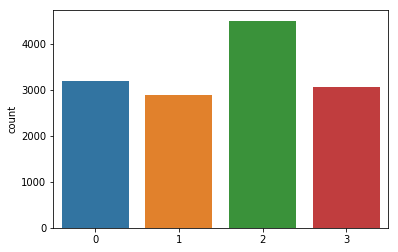

ValueError: min() arg is an empty sequence

In [27]:
sns.countplot(Z_train)
plt.show()

sns.countplot(Z_test)
plt.show()

### Load annotations / Generate

In [30]:
from code.representation import *
from code.utils import *

# data from Amazon Mechanical Turk
print("Loading AMT data...")
y_obs = np.loadtxt(folder+"answers_"+p_error+"_"+Q_s+".txt",dtype='int16')#not annotation symbol ==-1
#y_obs = y_obs[~mask_val]
T_weights = np.sum(y_obs != -1,axis=0) #distribucion de anotaciones

print("Remove %d annotators that do not annotate on this set "%(np.sum(T_weights==0)))
y_obs = y_obs[:,T_weights!=0]
T_weights = np.sum(y_obs != -1,axis=0) #distribucion de anotaciones

N,T = y_obs.shape
Kl = np.max(y_obs)+1 # asumiendo que estan ordenadas
print("Shape (data,annotators): ",(N,T))
print("Classes: ",Kl)

Loading AMT data...
Remove 0 annotators that do not annotate on this set 
Shape (data,annotators):  (25027, 1386)
Classes:  4


In [ ]:
#every annotation is one annotator
total_annotations = T_weights.sum(axis=0)
new_annotations = np.ones((N, total_annotations),dtype='int16')*-1
t_aux = 0
for i in range(y_obs.shape[0]):
    for t in range(y_obs.shape[1]):
        if y_obs[i,t] != -1:
            new_annotations[i,t_aux] = y_obs[i,t]
            t_aux+=1
new_annotations.shape

In [30]:
np.savetxt(folder+"answers_v2.txt",new_annotations, delimiter=",", fmt="%i")

In [31]:
#generate conf matrix...
confe_matrix_R = np.zeros((T,Kl,Kl),dtype=DTYPE_OP) #rodrigues add epsilon here
for t in range(T):    
    for i in range(N):
        if y_obs[i,t] != -1:
            confe_matrix_R[t,Z_train[i],y_obs[i,t]] +=1
            
    mask_nan = confe_matrix_R[t,:,:].sum(axis=-1) == 0
    mean_replace = np.mean(confe_matrix_R[t,:,:][~mask_nan],axis=0)
    for value in np.arange(Kl)[mask_nan]:
        #how to fill where she not annotate?? -- 
        confe_matrix_R[t,value,:] =  1 #Rodrigues 1./K -- similar  to laplace smooth (prior 1)
        #confe_matrix[t,value,:] = mean_replace #Ours
    confe_matrix_R[t,:,:] = confe_matrix_R[t,:,:]/confe_matrix_R[t,:,:].sum(axis=-1,keepdims=True) #normalize
confe_matrix_R

array([[[0.54385966, 0.21052632, 0.10526316, 0.14035088],
        [0.04761905, 0.5714286 , 0.21428572, 0.16666667],
        [0.        , 0.        , 0.8947368 , 0.10526316],
        [0.        , 0.        , 0.6938776 , 0.30612245]],

       [[1.        , 0.        , 0.        , 0.        ],
        [0.6363636 , 0.33333334, 0.        , 0.03030303],
        [0.        , 0.        , 0.5       , 0.5       ],
        [0.16      , 0.04      , 0.04      , 0.76      ]],

       [[0.33333334, 0.6666667 , 0.        , 0.        ],
        [0.        , 1.        , 0.        , 0.        ],
        [0.        , 0.        , 0.625     , 0.375     ],
        [0.        , 0.        , 0.4       , 0.6       ]],

       ...,

       [[0.25      , 0.25      , 0.25      , 0.25      ],
        [0.        , 1.        , 0.        , 0.        ],
        [0.25      , 0.25      , 0.25      , 0.25      ],
        [1.        , 0.        , 0.        , 0.        ]],

       [[0.        , 1.        , 0.        , 0.    

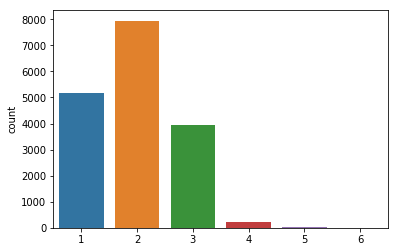

Minimum annotations in a example:  1
Maximum annotations in a example:  6
T data (expected value):  1.9566272018481086
Graphics of T weights


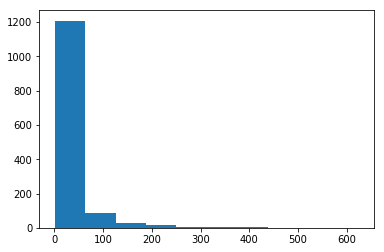

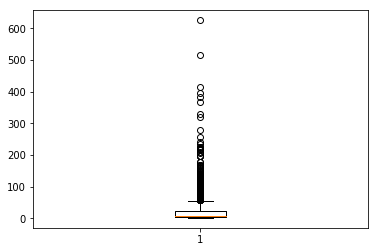

Minimum annotations by an annotator:  1
Maximum annotations by an annotator:  625
Mean annotations by an annotator:  25.076980014803848


In [70]:
#graphics and distribution? what is T_data
N_ann = np.sum(y_obs != -1,axis=1) #distribucion de anotaciones con este valor

sns.countplot(N_ann)
plt.show()
print("Minimum annotations in a example: ",N_ann.min())
print("Maximum annotations in a example: ",N_ann.max())
print("T data (expected value): ",N_ann.mean())

print("Graphics of T weights")
plt.hist(T_weights)
plt.show()

plt.boxplot(T_weights)
plt.show()
print("Minimum annotations by an annotator: ",T_weights.min())
print("Maximum annotations by an annotator: ",T_weights.max())
print("Mean annotations by an annotator: ",T_weights.mean())

#### Delta Convergence criteria

In [32]:
from code.learning_models import LogisticRegression_Sklearn,LogisticRegression_Keras,MLP_Keras
#deep learning
from code.learning_models import default_CNN,default_RNN,CNN_simple, RNN_simple, Clonable_Model

from code.utils import EarlyStopRelative
ourCallback = EarlyStopRelative(monitor='loss',patience=1,min_delta=TOL)

### Upper Bound Model -- ideal

In [33]:
Z_train_onehot = keras.utils.to_categorical(Z_train, num_classes=Kl)

model_UB = MLP_Keras(Xstd_train.shape[1:],Z_train_onehot.shape[1],128,1,BN=True,drop=0.5) 

model_UB.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_UB.fit(Xstd_train,Z_train_onehot,epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])

clone_UB = Clonable_Model(model_UB)
print("Trained IDeal Model, Epochs to converge =",len(hist.epoch))
Z_train_pred = model_UB.predict_classes(Xstd_train)
Z_val_pred = model_UB.predict_classes(Xstd_val)
Z_test_pred = model_UB.predict_classes(Xstd_test)

Trained IDeal Model, Epochs to converge = 5


In [52]:
Kl = Z_train.max()+1
Z_train_onehot = keras.utils.to_categorical(Z_train, num_classes=Kl)
Z_val_onehot = keras.utils.to_categorical(Z_val, num_classes=Kl)
Z_test_onehot = keras.utils.to_categorical(Z_test, num_classes=Kl)

In [53]:
model_UB = MLP_Keras(Xstd_train.shape[1:],Z_train_onehot.shape[1],128,2,BN=False,drop=0.5) #true bn?
model_UB.compile(loss='categorical_crossentropy',optimizer=OPT, metrics=["acc"])
model_UB.summary()
hist=model_UB.fit(Xstd_train,Z_train_onehot,epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=1,callbacks=[ourCallback]
                  ,validation_data=(Xstd_val,Z_val_onehot))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 516       
_________________________________________________________________
activation_1 (Activation)    (None, 4)                 0         
Total para

In [54]:
model_UB = MLP_Keras(Xstd_train.shape[1:],Z_train_onehot.shape[1],128,1,BN=True,drop=0.5) #true bn?
model_UB.compile(loss='categorical_crossentropy',optimizer=OPT, metrics=["acc"])
model_UB.summary()
hist=model_UB.fit(Xstd_train,Z_train_onehot,epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=1,callbacks=[ourCallback]
                  ,validation_data=(Xstd_val,Z_val_onehot))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               65664     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 516       
_________________________________________________________________
activation_2 (Activation)    (None, 4)                 0         
Total params: 66,692
Trainable params: 66,436
Non-trainable params: 256
_________________________________________________________________
Trai

In [55]:
model_UB = MLP_Keras(Xstd_train.shape[1:],Z_train_onehot.shape[1],128,2,BN=True,drop=0.5) #true bn?
model_UB.compile(loss='categorical_crossentropy',optimizer=OPT, metrics=["acc"])
model_UB.summary()
hist=model_UB.fit(Xstd_train,Z_train_onehot,epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=1,callbacks=[ourCallback]
                  ,validation_data=(Xstd_val,Z_val_onehot))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               65664     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
__________

In [87]:
clone_UB = Clonable_Model(model_UB)
print("Trained IDeal Model, Epochs to converge =",len(hist.epoch))
Z_train_pred = model_UB.predict_classes(Xstd_train)
Z_test_pred = model_UB.predict_classes(Xstd_test)

Trained IDeal Model, Epochs to converge = 4


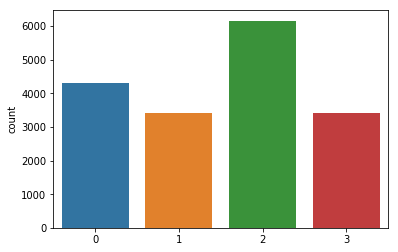

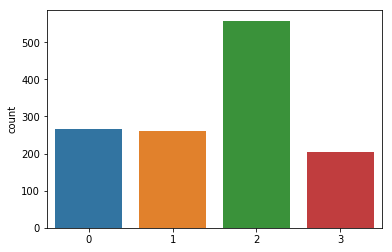

In [91]:
sns.countplot(Z_train_pred)
plt.show()
sns.countplot(Z_test_pred)
plt.show()

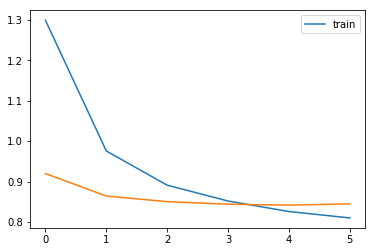

In [92]:
plt.plot(hist.history["loss"],label="train")
plt.plot(hist.history["val_loss"])
plt.legend()

In [33]:
from code.evaluation import Evaluation_metrics

N = Xstd_train.shape[0]
evaluate = Evaluation_metrics(model_UB,'keras',N)
print("*** Upper bound (Train with GT) ***")

print("Train")
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Upper bound (Train with GT) ***
Train
A result


,,Accuracy,F1 (micro),F1 (macro)
0,All,0.8238,0.8238,0.8109


Test
A result


,,Accuracy,F1 (micro),F1 (macro)
0,All,0.843,0.843,0.825


### Infer Labels (without predictive model)

In [79]:
from code.baseline import LabelInference

label_I = LabelInference(y_obs,TOL,type_inf = 'all')

mv_probas, mv_conf_probas = label_I.mv_labels('probas')
mv_onehot, mv_conf_onehot = label_I.mv_labels('onehot')

confe_matrix_G = get_Global_confusionM(Z_train,label_I.y_obs_repeat)

if y_obs.shape[1] <= 12000:
    ds_labels,ds_conf = label_I.DS_labels()

Representation for MV in 0.754232 sec
Representation for DS in 0.578112 sec
Estimation MV in 0.001040 sec
Iter	log-likelihood	delta-CM	delta-ER	delta-LL
1 	 -34875.36960012488
2 	 -33797.96251874367 	0.0193	0.305034	0.030893
3 	 -33451.381532317304 	0.0131	0.071528	0.010254
4 	 -33256.66848447198 	0.0078	0.066143	0.005821
5 	 -33132.509977173235 	0.0050	0.063487	0.003733
6 	 -33047.71422557834 	0.0046	0.060051	0.002559
7 	 -32986.88016410955 	0.0044	347.021271	0.001841
8 	 -32941.447285139635 	0.0042	0.052233	0.001377
9 	 -32906.56945848786 	0.0039	0.048752	0.001059
10 	 -32879.14200719682 	0.0037	0.045450	0.000833
11 	 -32857.20622208775 	0.0034	0.042328	0.000667
12 	 -32839.62964322639 	0.0031	0.039510	0.000535
13 	 -32825.47708083321 	0.0029	0.036761	0.000431
14 	 -32813.862151244255 	0.0027	0.034040	0.000354
15 	 -32804.06698408639 	0.0024	0.031303	0.000299
16 	 -32795.70814715521 	0.0023	346.994019	0.000255
17 	 -32788.388562598404 	0.0021	0.026505	0.000223
Class marginals
[0.24 0

In [34]:
from code.baseline import LabelInference

label_I = LabelInference(y_obs,TOL,type_inf = 'all')

mv_probas, mv_conf_probas = label_I.mv_labels('probas')
mv_onehot, mv_conf_onehot = label_I.mv_labels('onehot')
confe_matrix_G = get_Global_confusionM(Z_train,label_I.y_obs_repeat)

Representation for MV in 0.459586 sec
Representation for DS in 0.725737 sec
Estimation MV in 0.001641 sec


In [35]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))
print("F1 MV  on train:",f1_score(Z_train,mv_onehot.argmax(axis=1),average="macro"))

print("ACC D&S on train:",np.mean(ds_labels.argmax(axis=1)==Z_train))
print("F1 D&S  on train:",f1_score(Z_train,ds_labels.argmax(axis=1),average="macro"))

ACC MV on train: 0.6018699804211451
F1 MV  on train: 0.5810237929992176


NameError: name 'ds_labels' is not defined

In [37]:
model_mvsoft = clone_UB.get_model()
model_mvsoft.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_mvsoft.fit(Xstd_train, mv_probas, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over soft-MV, Epochs to converge =",len(hist.epoch))
Z_train_pred = model_mvsoft.predict_classes(Xstd_train)
Z_val_pred = model_mvsoft.predict_classes(Xstd_val)
Z_test_pred = model_mvsoft.predict_classes(Xstd_test)

Trained model over soft-MV, Epochs to converge = 4


In [39]:
model_mvhard = clone_UB.get_model()
model_mvhard.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_mvhard.fit(Xstd_train, mv_onehot, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over hard-MV, Epochs to converge =",len(hist.epoch))
Z_train_pred = model_mvhard.predict_classes(Xstd_train)
Z_val_pred = model_mvhard.predict_classes(Xstd_val)
Z_test_pred = model_mvhard.predict_classes(Xstd_test)

Trained model over hard-MV, Epochs to converge = 4


In [85]:
model_ds = clone_UB.get_model()
model_ds.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_ds.fit(Xstd_train, ds_labels, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over D&S, Epochs to converge =",len(hist.epoch))
Z_train_pred = model_ds.predict_classes(Xstd_train)
Z_val_pred = model_ds.predict_classes(Xstd_val)
Z_test_pred = model_ds.predict_classes(Xstd_test)

Trained model over D&S, Epochs to converge = 4


### Raykar Model (joint predict model)

In [41]:
from code.baseline import RaykarMC
y_obs_categorical = set_representation(y_obs,'onehot') #for raykar
print("shape:",y_obs_categorical.shape)

shape: (25027, 1386, 4)


In [42]:
raykarMC = RaykarMC(Xstd_train.shape[1:],y_obs_categorical.shape[-1],T,epochs=1,optimizer=OPT,DTYPE_OP=DTYPE_OP)
raykarMC.define_model("mlp",128,1,BatchN=True,drop=0.5) #otro

logL_hists,i_r = raykarMC.multiples_run(20,Xstd_train,y_obs_categorical,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,
                                     tolerance=TOL)

Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Betas shape:  (1386, 4, 4)
Q estimate shape:  (25027, 4)
Iter 1/50 
M step: done,  E step: done //  (in 3.31 sec)	logL: -42253.484	
Iter 2/50 
M step: done,  E step: done //  (in 1.40 sec)	logL: -39484.688	Tol1: 0.06553	Tol2: 0.14696	
Iter 3/50 
M step: done,  E step: done //  (in 1.19 sec)	logL: -38116.609	Tol1: 0.03465	Tol2: 0.05484	
Iter 4/50 
M step: done,  E step: done //  (in 1.40 sec)	logL: -37266.375	Tol1: 0.02231	Tol2: 0.03597	
Iter 5/50 
M step: done,  E step: done //  (in 1.67 sec)	logL: -36684.133	Tol1: 0.01562	Tol2: 0.02933	
Finished training
Initializing new EM...
Betas shape:  (1386, 4, 4)
Q estimate shape:  (25027, 4)
Iter 1/50 
M step: done,  E step: done //  (in 2.39 sec)	logL: -42202.918	
Iter 2/50 
M step: done,  E step: done //  (in 1.30 sec)	logL: -39470.320	Tol1: 0.06475	Tol2: 0.14962	
Iter 3/50 
M step: done,  E step: done //  (in 1.29 sec)	logL: -38190.141	Tol1: 0.03243	Tol2: 0.05616	
Iter 4/50 
M s

M step: done,  E step: done //  (in 1.47 sec)	logL: -38097.492	Tol1: 0.03484	Tol2: 0.05712	
Iter 4/50 
M step: done,  E step: done //  (in 1.59 sec)	logL: -37115.602	Tol1: 0.02577	Tol2: 0.03720	
Iter 5/50 
M step: done,  E step: done //  (in 1.66 sec)	logL: -36507.383	Tol1: 0.01639	Tol2: 0.03024	
Iter 6/50 
M step: done,  E step: done //  (in 1.64 sec)	logL: -36047.152	Tol1: 0.01261	Tol2: 0.02134	
Finished training
Initializing new EM...
Betas shape:  (1386, 4, 4)
Q estimate shape:  (25027, 4)
Iter 1/50 
M step: done,  E step: done //  (in 2.88 sec)	logL: -42328.926	
Iter 2/50 
M step: done,  E step: done //  (in 1.61 sec)	logL: -39559.988	Tol1: 0.06541	Tol2: 0.14829	
Iter 3/50 
M step: done,  E step: done //  (in 1.62 sec)	logL: -38073.965	Tol1: 0.03756	Tol2: 0.05604	
Iter 4/50 
M step: done,  E step: done //  (in 1.62 sec)	logL: -37203.031	Tol1: 0.02287	Tol2: 0.03852	
Iter 5/50 
M step: done,  E step: done //  (in 1.70 sec)	logL: -36605.195	Tol1: 0.01607	Tol2: 0.02875	
Finished train

In [43]:
Z_train_p = raykarMC.get_predictions(Xstd_train)
Z_train_pred =Z_train_p.argmax(axis=-1)
Z_val_pred = raykarMC.get_predictions(Xstd_val).argmax(axis=-1)
Z_test_pred = raykarMC.get_predictions(Xstd_test).argmax(axis=-1)

### Our Proposed

In [159]:
from code.MixtureofGroups import GroupMixtureGlo, GroupMixtureInd

In [160]:
""" AÑADIR A ARCHIVO GROUPS..."""
def define_uniform_groups(power, r, M):
    R_total = r.sum()
    uniform_groups = np.asarray([power*R_total/M for _ in range(M)])
    return uniform_groups


#get our representation 
r_obs = set_representation(y_obs,"repeat")
#r_obs = label_I.y_obs_repeat.copy()

confe_matrix_G = get_Global_confusionM(Z_train,r_obs)

print("vector of repeats:\n",r_obs)
print("shape:",r_obs.shape)

vector of repeats:
 [[0 0 1 1]
 [1 1 0 0]
 [0 0 2 1]
 ...
 [0 0 0 1]
 [0 1 0 0]
 [2 0 0 0]]
shape: (19402, 4)


Normalized entropy (0-1) of repeats annotations: 0.06213511502976383


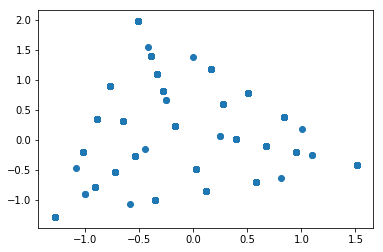

In [22]:
mv_soft = majority_voting(r_obs,repeats=True,probas=True) 
aux = []
for example in mv_soft:
    aux.append(entropy(example)/np.log(Kl))
print("Normalized entropy (0-1) of repeats annotations:",np.mean(aux))

from code.MixtureofGroups import *
predicted = np.clip(mv_soft, keras.backend.epsilon(), 1.)
data_to_cluster = []
for i in range(mv_soft.shape[0]):
    for j in range(mv_soft.shape[1]):
        ob = np.tile(keras.backend.epsilon(), mv_soft.shape[1])
        ob[j] = 1
        true = np.clip(predicted[i],keras.backend.epsilon(),1.)      
        f_l = distance_function(true, ob)  #funcion de distancia o similaridad
        data_to_cluster.append(f_l)  
data_to_cluster = np.asarray(data_to_cluster)
model = PCA(n_components=min(3,mv_soft.shape[0]) ) 
data_to_cluster = model.fit_transform(data_to_cluster)

std = StandardScaler(with_mean=True,with_std=True)
data_to_plot = std.fit_transform(data_to_cluster)
plt.scatter(data_to_plot[:,0],data_to_plot[:,1])
plt.show()

There is low entropy (information), maybe there is only a few groups in this dataset, the possible of different behavior is low.

Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Doing clustering...Done!
Get init alphas in 0.041659 mins
Lambda by group:  [1. 1. 1. 1. 1.]
Alphas:  (5,)
MV init:  (17363, 4)
Betas:  (5, 4, 4)
Q estimate:  (17363, 4, 5, 4)
Iter 1/0
M step: done,  E step: done //  (in 1.06 sec)	logL: -67392.492	
Finished training!


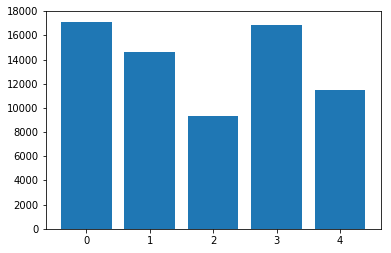

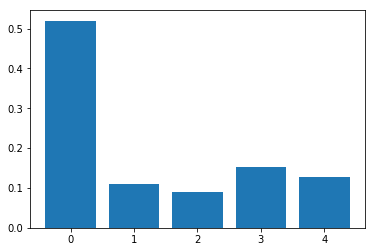

In [21]:
gMixture_Global = GroupMixtureGlo(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=5,epochs=0,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture_Global.define_model("mlp",128,1,BatchN=True,drop=0.5)
gMixture_Global.lambda_random = True 
logL_hists,i_r = gMixture_Global.multiples_run(1,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=0,tolerance=TOL)

aux = gMixture_Global.alpha_init.sum(axis=1).sum(axis=0)
plt.bar(np.arange(gMixture_Global.M),aux)
plt.show()
gMixture_Global.get_alpha()
plt.bar(np.arange(gMixture_Global.M),gMixture_Global.get_alpha())
plt.show()

In [20]:
#T if i know T
print(T)
M_values = range(1,1+len(logL_Mchange))
t = pd.DataFrame()
t["#Groups"] = M_values
t[">=1 annotator"] = [ np.sum(probas*T >= 1) for probas in probas_Mchange]
t[">=2 annotator"] = [ np.sum(probas*T >= 2) for probas in probas_Mchange] #si agrupa al menos tiene 2
t["Used on annotators"] = [ len(np.unique(prob_Gt.argmax(axis=1))) for prob_Gt in probGt_Mchange ]#based on p(g|t)
t["Used on annotators limit >=0.01"] = [ np.sum(prob_Gt.max(axis=0)>=0.01) for prob_Gt in probGt_Mchange ]#based on p(g|t)
t["Used on annotators limit >=0.05"] = [ np.sum(prob_Gt.max(axis=0)>=0.05) for prob_Gt in probGt_Mchange ]#based on p(g|t)
t

459


NameError: name 'logL_Mchange' is not defined

1, 2 o 3...

In [161]:
M_seted = 3 #??

uniform = False
if uniform:
    uniform_groups = define_uniform_groups(0.1, r_obs, M_seted)
    print(uniform_groups)

In [162]:
gMixture_Global = GroupMixtureGlo(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=M_seted,epochs=1,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture_Global.define_model("mlp",128,1,BatchN=True,drop=0.5)

if uniform:
    gMixture_Global.define_priors("laplace")
    gMixture_Global.define_priors(uniform_groups)

gMixture_Global.lambda_random = False 
logL_hists,i_r = gMixture_Global.multiples_run(1,Xstd_train,r_obs,
                                               batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL*5/3)

Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Doing clustering...Done!
Get init alphas in 0.063289 mins
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (19402, 4)
Betas:  (3, 4, 4)
Q estimate:  (19402, 4, 3, 4)
Iter 1/50
M step: done,  E step: done //  (in 3.34 sec)	logL: -40711.726	
Iter 2/50
M step: done,  E step: done //  (in 0.90 sec)	logL: -39247.808	Tol1: 0.03596	Tol2: 0.30602	Tol3: 0.02017	
Iter 3/50
M step: done,  E step: done //  (in 0.87 sec)	logL: -38831.075	Tol1: 0.01062	Tol2: 0.17421	Tol3: 0.00641	
Iter 4/50
M step: done,  E step: done //  (in 0.94 sec)	logL: -38545.303	Tol1: 0.00736	Tol2: 0.11798	Tol3: 0.00442	
Iter 5/50
M step: done,  E step: done //  (in 0.96 sec)	logL: -38176.741	Tol1: 0.00956	Tol2: 0.09352	Tol3: 0.00584	
Iter 6/50
M step: done,  E step: done //  (in 0.94 sec)	logL: -37933.109	Tol1: 0.00638	Tol2: 0.08706	Tol3: 0.00822	
Iter 7/50
M step: done,  E step: done //  (in 0.97 sec)	logL: -37621.880	Tol1: 0.00820	Tol2: 0.07675	Tol3: 0.0202

In [165]:
Z_train_p = gMixture_Global.get_predictions(Xstd_train)
Z_train_pred = Z_train_p.argmax(axis=-1)
Z_val_p = gMixture_Global.get_predictions(Xstd_val)
Z_val_pred = Z_val_p.argmax(axis=-1)
Z_test_p = gMixture_Global.get_predictions(Xstd_test)
Z_test_pred = Z_test_p.argmax(axis=-1)

In [26]:
plt.figure(figsize=(15,7))
for a, value in enumerate(logL_hists): #logL_hists
    if a != i_r:
        plt.plot(range(len(value)),value,'.-')
plt.plot(range(len(logL_hists[i_r])),logL_hists[i_r],'o-',markersize=10,label="Selected run")
plt.legend()
plt.show()

TypeError: object of type 'numpy.float64' has no len()

<Figure size 1080x504 with 0 Axes>

In [167]:
Y_ann_train, T_idx = set_representation(y_obs,"onehotvar")
T_idx_unique = np.arange(T).reshape(-1,1)

A = keras.utils.to_categorical(np.arange(T), num_classes=T) #fast way
print("shape of annotator representation (T, R_t)=", A.shape)

shape of annotator representation (T, R_t)= (1361, 1361)


shape of annotator representation (T, R_t)= (1361, 16)


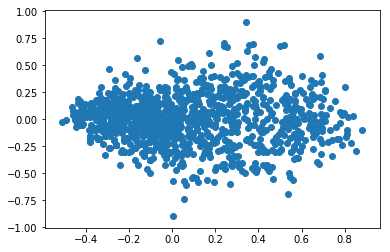

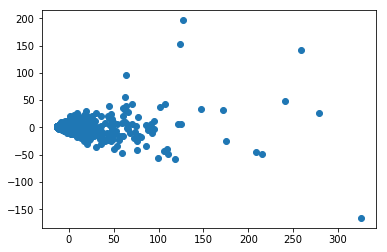

array([[25., 36., 83., 29.],
       [37.,  6.,  7., 21.],
       [ 2.,  2.,  8.,  4.],
       ...,
       [ 1.,  0.,  2.,  0.],
       [ 0.,  2.,  0.,  0.],
       [ 0.,  1.,  1.,  0.]])

In [168]:
from code.MixtureofGroups import *
conf_mat, conf_mat_norm  = build_conf_Yvar(Y_ann_train, T_idx, r_obs.argmax(axis=-1))

A_rep = conf_mat_norm.reshape(conf_mat_norm.shape[0], Kl**2) #flatten
#A_rep = np.zeros((conf_mat.shape[0], Kl))
#for t in range(A_rep.shape[0]):
#    A_rep[t] = JS_confmatrixs(conf_mat_norm[t], np.identity(Kl),raw=True) #distancia a I (MV)
    
print("shape of annotator representation (T, R_t)=", A_rep.shape)

from sklearn.decomposition import PCA
model = PCA(2)
aux_pca = model.fit_transform(A_rep)
plt.scatter(aux_pca[:,0],aux_pca[:,1])
plt.show()


A_rep = np.zeros((y_obs.shape[1], Kl))
for i in range(N):
    for l, t_idx in enumerate(T_idx[i]):
        obs_t = Y_ann_train[i][l].argmax(axis=-1)
        A_rep[t_idx, obs_t] += 1
    
from sklearn.decomposition import PCA
model = PCA(2)
aux_pca = model.fit_transform(A_rep)
plt.scatter(aux_pca[:,0],aux_pca[:,1])
plt.show()
A_rep

In [169]:
#different M_seted??
M_seted = 3

In [170]:
gMixture_Ind1 = GroupMixtureInd(Xstd_train.shape[1:],Kl=Kl,M=M_seted,epochs=1,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture_Ind1.define_model("mlp",128,1,BatchN=True,drop=0.5)

#gMixture_Ind.define_model_group("mlp", T, M_seted, 1, BatchN=True, embed=True, embed_M=A) #con o sin BN
gMixture_Ind1.define_model_group("perceptron",T, M_seted, embed=True, embed_M=A, BatchN=True,bias=False)

logL_hists,i = gMixture_Ind1.multiples_run(1,Xstd_train,Y_ann_train, T_idx, A=[], batch_size=BATCH_SIZE,
                                    pre_init_z=3,pre_init_g=0,max_iter=EPOCHS_BASE,tolerance=TOL*5/3)

Needed params (units,deep,drop,BatchN?)
Initializing new EM...
A = Son ortonormales / No fueron entregados!
Doing clustering...Done!
Get init alphas in 0.002219 mins
Lambda by group:  [1. 1. 1.]
Pre-train networks over *z* on 3 epochs... Done!
MV init:  (19402, 4)
Betas:  (3, 4, 4)
Q estimate:  (37782, 3, 4)
Iter 1/50
M step: done,  E step: done //  (in 6.90 sec)	logL: -39787.774	
Iter 2/50
M step: done,  E step: done //  (in 1.87 sec)	logL: -38004.306	Tol1: 0.04482	Tol2: 0.23823	
Iter 3/50
M step: done,  E step: done //  (in 1.98 sec)	logL: -37124.403	Tol1: 0.02315	Tol2: 0.20678	
Iter 4/50
M step: done,  E step: done //  (in 2.01 sec)	logL: -36385.977	Tol1: 0.01989	Tol2: 0.18136	
Iter 5/50
M step: done,  E step: done //  (in 2.04 sec)	logL: -35787.638	Tol1: 0.01644	Tol2: 0.16163	
Iter 6/50
M step: done,  E step: done //  (in 1.88 sec)	logL: -35117.250	Tol1: 0.01873	Tol2: 0.16999	
Iter 7/50
M step: done,  E step: done //  (in 1.85 sec)	logL: -34558.808	Tol1: 0.01590	Tol2: 0.15307	
Iter

In [171]:
Z_train_p = gMixture_Ind1.get_predictions_z(Xstd_train)
Z_train_pred = Z_train_p.argmax(axis=-1)
Z_val_p = gMixture_Ind1.get_predictions_z(Xstd_val)
Z_val_pred = Z_val_p.argmax(axis=-1)
Z_test_p = gMixture_Ind1.get_predictions_z(Xstd_test)
Z_test_pred = Z_test_p.argmax(axis=-1)
prob_Gt = gMixture_Ind1.get_predictions_g(T_idx_unique) 

In [30]:
gMixture_Ind2 = GroupMixtureInd(Xstd_train.shape[1:],Kl=Kl,M=M_seted,epochs=1,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture_Ind2.define_model("mlp",128,1,BatchN=True,drop=0.5)
#gMixture_Ind.define_model_group("mlp", T, M_seted, 1, BatchN=True, embed=True, embed_M=A) #con o sin BN
#gMixture_Ind.define_model_group("keras_shallow", T, M_seted,embed=True, embed_M=A) #pareciera ser necesario pr-init

logL_hists,i = gMixture_Ind2.multiples_run(20,Xstd_train,Y_ann_train, T_idx, A=[], batch_size=BATCH_SIZE,
                                    pre_init_z=3,pre_init_g=0,max_iter=EPOCHS_BASE,tolerance=TOL)

NameError: name 'Xstd_train' is not defined

In [38]:
A_rep = A_rep/A_rep.sum(axis=-1,keepdims=True)
A_rep

array([[0.12162162, 0.2027027 , 0.51351351, 0.16216216],
       [0.52857143, 0.08571429, 0.1       , 0.28571429],
       [0.13333333, 0.13333333, 0.53333333, 0.2       ],
       ...,
       [0.2       , 0.8       , 0.        , 0.        ],
       [0.        , 0.5       , 0.5       , 0.        ],
       [0.        , 1.        , 0.        , 0.        ]])

In [45]:
gMixture_Ind3 = GroupMixtureInd(Xstd_train.shape[1:],Kl=Kl,M=M_seted,epochs=1,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture_Ind3.define_model("mlp",128,1,BatchN=True,drop=0.5)
gMixture_Ind3.define_model_group("mlp", A_rep.shape[1], Kl*M_seted, 1, BatchN=False, embed=False) #con BN y A norm

logL_hists,i_r = gMixture_Ind3.multiples_run(1,Xstd_train,Y_ann_train, T_idx, A=A_rep, batch_size=BATCH_SIZE,
                                   pre_init_z=3,pre_init_g=0,max_iter=EPOCHS_BASE,tolerance=TOL*5/3) 

Needed params (units,deep,drop,BatchN?)
Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Doing clustering...Done!
Get init alphas in 0.000258 mins
Lambda by group:  [1. 1. 1.]
Pre-train networks over *z* on 3 epochs... Done!
MV init:  (17331, 4)
Betas:  (3, 4, 4)
Q estimate:  (33746, 3, 4)
Iter 1/50
M step: done,  E step: done //  (in 4.13 sec)	logL: -35946.977	
Iter 2/50
M step: done,  E step: done //  (in 1.33 sec)	logL: -34538.540	Tol1: 0.03918	Tol2: 0.25040	
Iter 3/50
M step: done,  E step: done //  (in 1.28 sec)	logL: -33782.731	Tol1: 0.02188	Tol2: 0.20455	
Iter 4/50
M step: done,  E step: done //  (in 1.42 sec)	logL: -33292.438	Tol1: 0.01451	Tol2: 0.16790	
Iter 5/50
M step: done,  E step: done //  (in 1.25 sec)	logL: -32842.724	Tol1: 0.01351	Tol2: 0.14674	
Iter 6/50
M step: done,  E step: done //  (in 1.38 sec)	logL: -32446.367	Tol1: 0.01207	Tol2: 0.13691	
Iter 7/50
M step: done,  E step: done //  (in 1.35 sec)	logL: -32150.262	Tol1: 0.00913	Tol2: 0.12532	
Iter 8/50

In [46]:
Z_train_p = gMixture_Ind3.get_predictions_z(Xstd_train)
Z_train_pred = Z_train_p.argmax(axis=-1)
Z_val_p = gMixture_Ind3.get_predictions_z(Xstd_val)
Z_val_pred = Z_val_p.argmax(axis=-1)
Z_test_p = gMixture_Ind3.get_predictions_z(Xstd_test)
Z_test_pred = Z_test_p.argmax(axis=-1)
prob_Gt = gMixture_Ind3.get_predictions_g(A_rep) 

### Compare trained models

In [17]:
#Import it:
from code.evaluation import Evaluation_metrics

colors = {0: 'b', 1:'r' ,2:'g'}
marker_s = {0: 'X', 1:'o', 2:'P'}

def plot_alphas(alphas_training):
    values = np.asarray(alphas_training)
    if len(values.shape) == 3:
        group_f = values[-1].argmax(axis=-1) #coloreado por el grupo del final..
        
        for m in range(M_seted):
            plt.figure(figsize=(15,7))
            for t in range(values.shape[1]):
                plt.plot(values[:,t,m], color=colors[group_f[t]], markersize=5)
            plt.title("Group "+str(m))
            plt.show()

        plt.figure(figsize=(15,10))
        for t in range(values.shape[1]):
            grupos_t_train = values[:,t,:].argmax(axis=-1)+t/values.shape[1]
            plt.plot(grupos_t_train, markersize=5, color=colors[group_f[t]])
            #plt.plot(grupos_t_train, markersize=5, marker=marker_s[group_f[t]])

        for m in range(M_seted+1):
            plt.hlines(m, 0,values.shape[0], linestyles="dashed")
        plt.show()
        
    else:
        plt.figure(figsize=(15,7))
        for m in range(M_seted):
            plt.plot(values[:,m], color=colors[m], markersize=5, label="Group "+str(m))
        plt.legend()
        plt.show()

In [36]:
evaluate = Evaluation_metrics(model_UB,'keras',Xstd_train.shape[0])
print("*** Upper bound (Train with GT) ***")

print("Train")
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_val,Z_pred=Z_val_pred)

*** Upper bound (Train with GT) ***
Train
A result


,,Accuracy,F1 (micro),F1 (macro)
0,All,0.6832,0.6832,0.672


Test
A result


,,Accuracy,F1 (micro),F1 (macro)
0,All,0.7892,0.7892,0.7489


*** Soft-Majority (Train with softMV) ***
Train
Calculate confusion matrix on repeat version


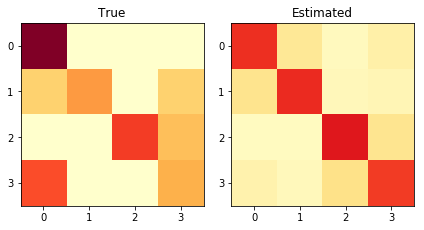

JS divergence: 0.1607	Norm Frobenius: 0.2088


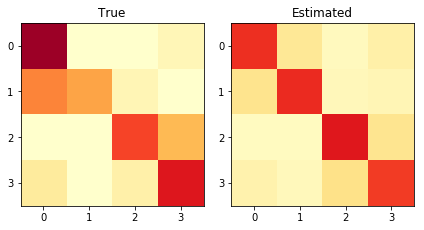

JS divergence: 0.0844	Norm Frobenius: 0.1494


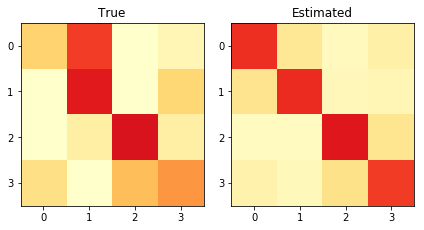

JS divergence: 0.1199	Norm Frobenius: 0.1946


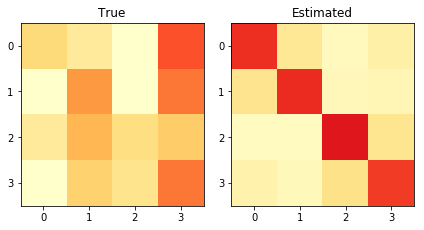

JS divergence: 0.2301	Norm Frobenius: 0.2857


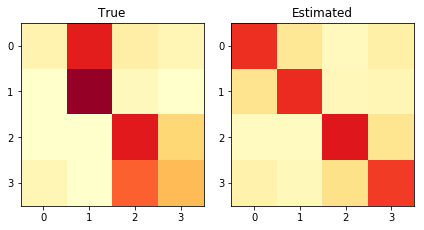

JS divergence: 0.1678	Norm Frobenius: 0.2612


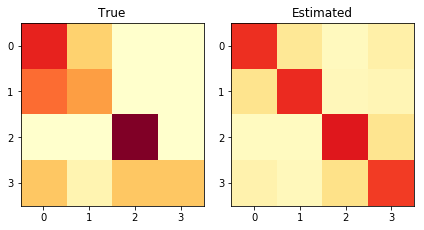

JS divergence: 0.1206	Norm Frobenius: 0.1834


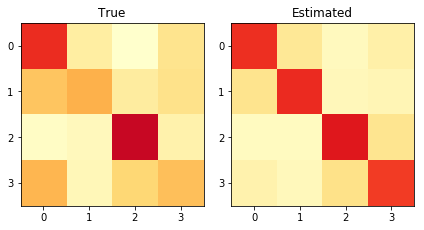

JS divergence: 0.0587	Norm Frobenius: 0.1502


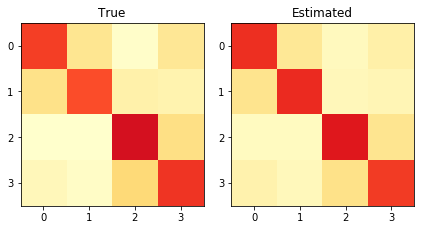

JS divergence: 0.0164	Norm Frobenius: 0.0388


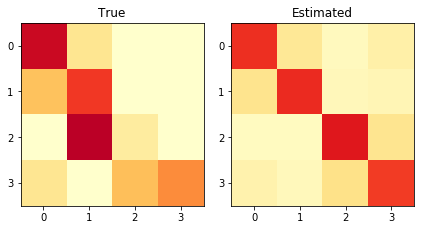

JS divergence: 0.2104	Norm Frobenius: 0.2802


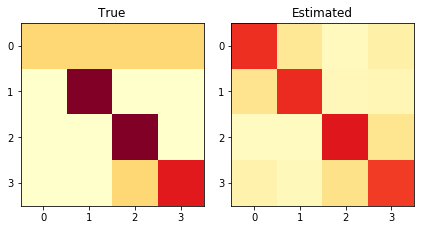

JS divergence: 0.1342	Norm Frobenius: 0.1779


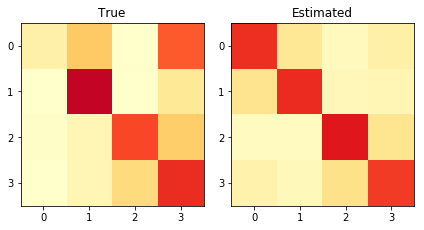

JS divergence: 0.1387	Norm Frobenius: 0.2125


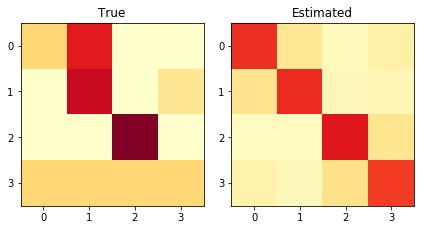

JS divergence: 0.1825	Norm Frobenius: 0.2452


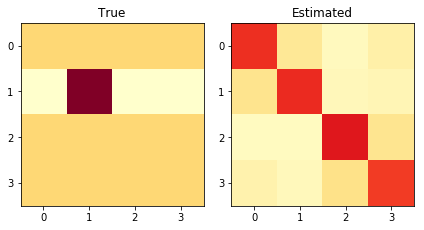

JS divergence: 0.1813	Norm Frobenius: 0.2499


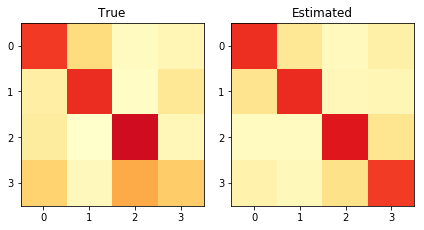

JS divergence: 0.0523	Norm Frobenius: 0.1288


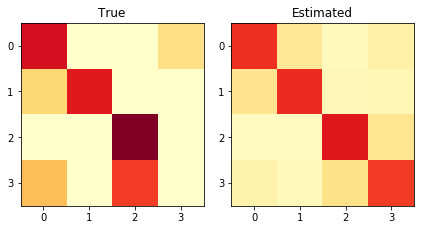

JS divergence: 0.2047	Norm Frobenius: 0.2348
Calculate confusion matrix on global version


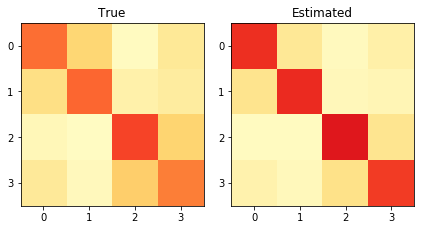

JS divergence: 0.0160	Norm Frobenius: 0.0811
A result


,,Accuracy,F1 (micro),F1 (macro),(R) NormF mean,(R) JS mean,(R) NormF w,(R) JS w,(G) NormF,(G) JS
0,All,0.6255,0.6255,0.6128,0.2727,0.2255,0.2144,0.1521,0.0811,0.016


Val
A result


,,Accuracy,F1 (micro),F1 (macro)
0,All,0.7613,0.7613,0.7174


Test
A result


,,Accuracy,F1 (micro),F1 (macro)
0,All,0.7613,0.7613,0.7174


In [38]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
prob_Yzt = np.tile( mv_conf_probas, (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     conf_true_G =confe_matrix_G, conf_pred_G = mv_conf_probas)

print("Val")
results2 = evaluate.calculate_metrics(Z=Z_val,Z_pred=Z_val_pred)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Hard-Majority (Train with hardMV) ***
Train
Calculate confusion matrix on repeat version


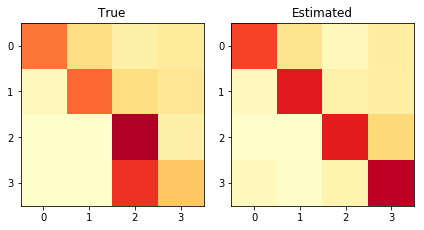

JS divergence: 0.1014	Norm Frobenius: 0.2242


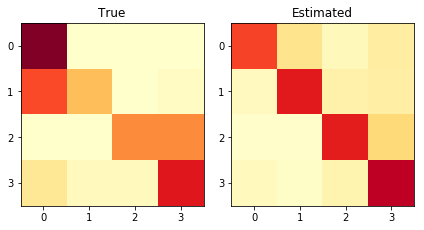

JS divergence: 0.1639	Norm Frobenius: 0.2338


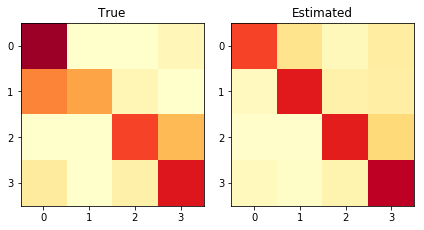

JS divergence: 0.1140	Norm Frobenius: 0.1794


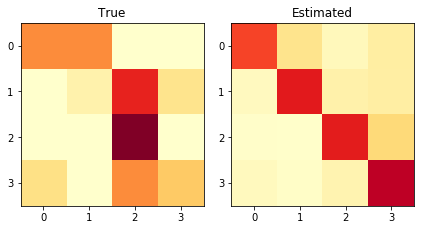

JS divergence: 0.2506	Norm Frobenius: 0.3198


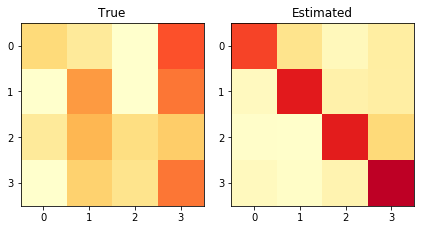

JS divergence: 0.2318	Norm Frobenius: 0.2869


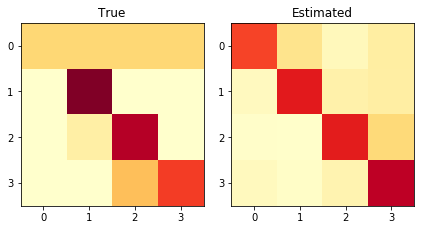

JS divergence: 0.1375	Norm Frobenius: 0.1781


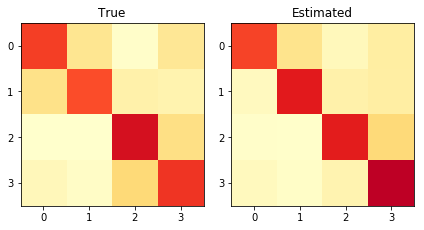

JS divergence: 0.0267	Norm Frobenius: 0.0822


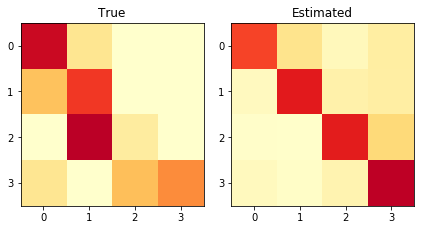

JS divergence: 0.2862	Norm Frobenius: 0.3137


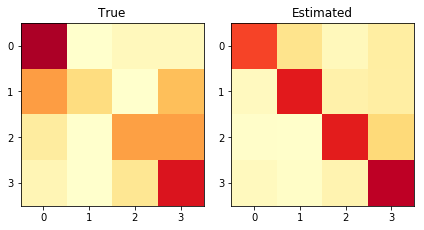

JS divergence: 0.1440	Norm Frobenius: 0.2193


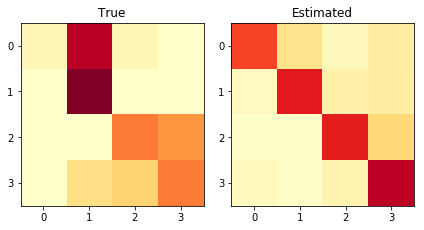

JS divergence: 0.1971	Norm Frobenius: 0.2751


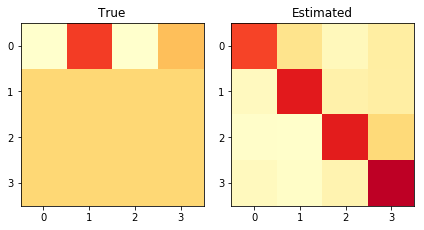

JS divergence: 0.3302	Norm Frobenius: 0.3468


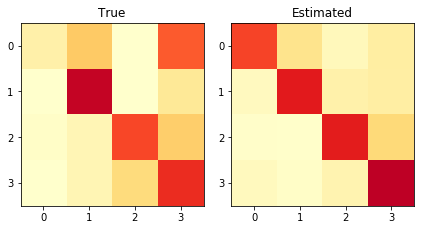

JS divergence: 0.1221	Norm Frobenius: 0.2003


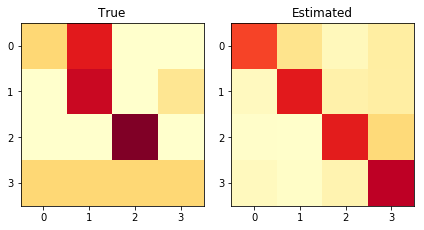

JS divergence: 0.2047	Norm Frobenius: 0.2691


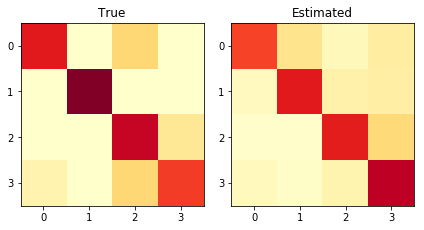

JS divergence: 0.1041	Norm Frobenius: 0.1308


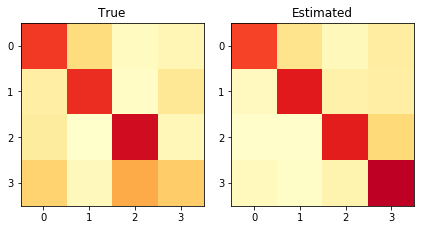

JS divergence: 0.1007	Norm Frobenius: 0.1879
Calculate confusion matrix on global version


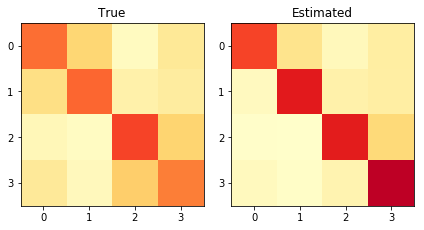

JS divergence: 0.0474	Norm Frobenius: 0.1263
A result


,,Accuracy,F1 (micro),F1 (macro),(R) NormF mean,(R) JS mean,(R) NormF w,(R) JS w,(G) NormF,(G) JS
0,All,0.6045,0.6045,0.5193,0.2883,0.2426,0.2369,0.1739,0.1263,0.0474


Val
A result


,,Accuracy,F1 (micro),F1 (macro)
0,All,0.7406,0.7406,0.6062


Test
A result


,,Accuracy,F1 (micro),F1 (macro)
0,All,0.7406,0.7406,0.6062


In [40]:
evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
prob_Yzt = np.tile( mv_conf_onehot, (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     conf_true_G =confe_matrix_G, conf_pred_G = mv_conf_onehot)

print("Val")
results2 = evaluate.calculate_metrics(Z=Z_val,Z_pred=Z_val_pred)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Dawid and Skene model (Train with D&S) ***
Train
Calculate confusion matrix on repeat version


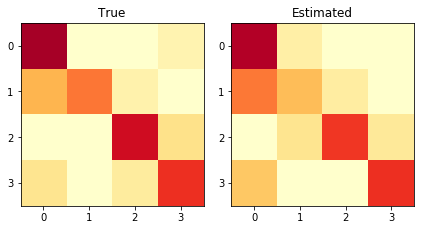

JS divergence: 0.0739	Norm Frobenius: 0.1047


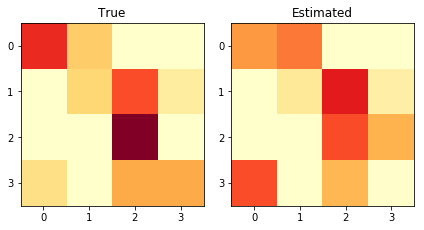

JS divergence: 0.1335	Norm Frobenius: 0.2187


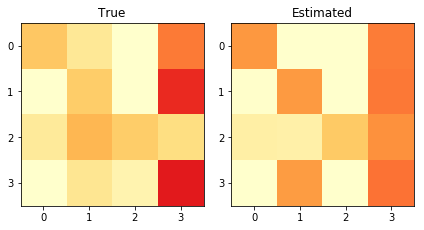

JS divergence: 0.0741	Norm Frobenius: 0.1520


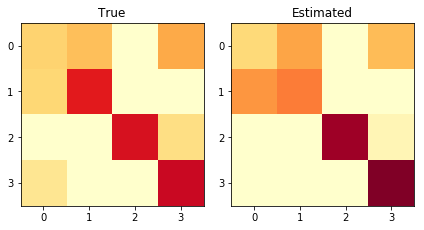

JS divergence: 0.0416	Norm Frobenius: 0.1129


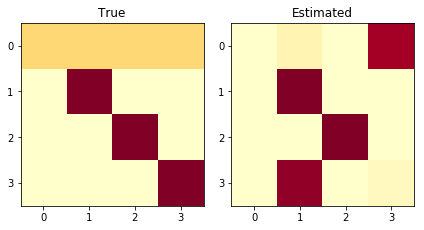

JS divergence: 0.3303	Norm Frobenius: 0.3928


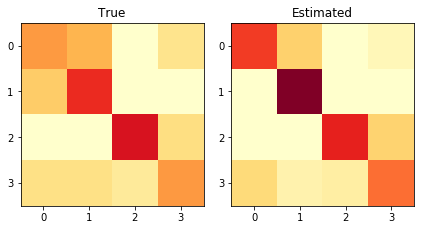

JS divergence: 0.0582	Norm Frobenius: 0.1300


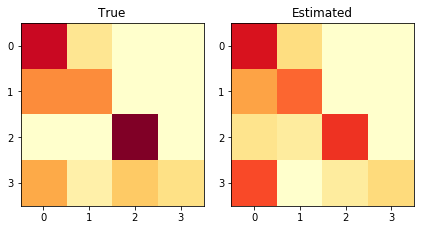

JS divergence: 0.0696	Norm Frobenius: 0.1271


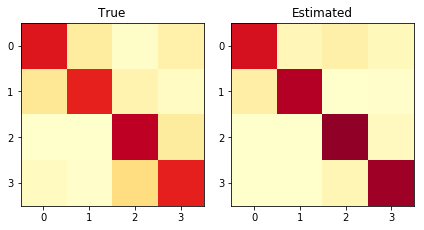

JS divergence: 0.0447	Norm Frobenius: 0.0903


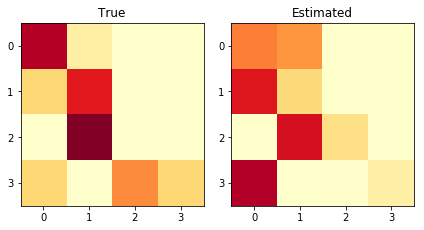

JS divergence: 0.2048	Norm Frobenius: 0.3108


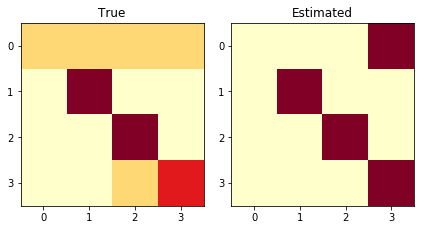

JS divergence: 0.1698	Norm Frobenius: 0.2336


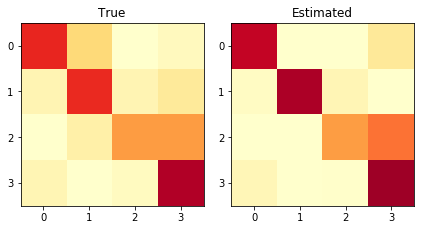

JS divergence: 0.0718	Norm Frobenius: 0.1032


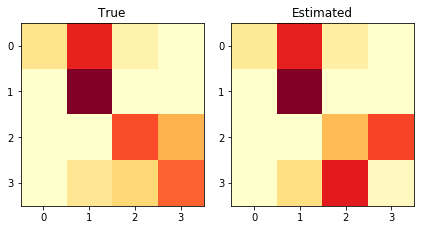

JS divergence: 0.0903	Norm Frobenius: 0.2097


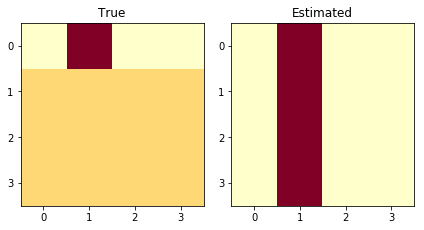

JS divergence: 0.4116	Norm Frobenius: 0.3750


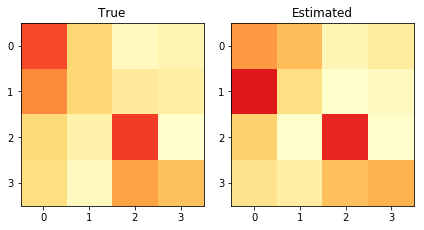

JS divergence: 0.0498	Norm Frobenius: 0.1022


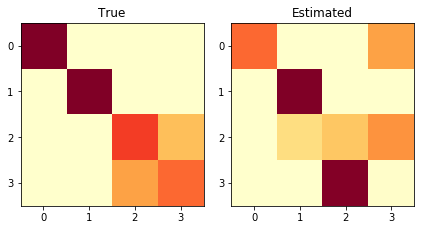

JS divergence: 0.1899	Norm Frobenius: 0.2730
Calculate confusion matrix on global version


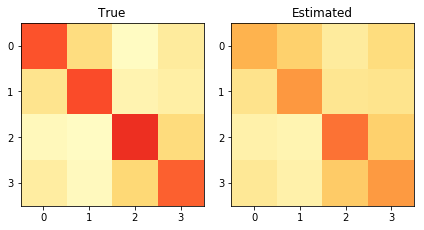

JS divergence: 0.0318	Norm Frobenius: 0.1051
A result


,,Accuracy,F1 (micro),F1 (macro),(R) NormF mean,(R) JS mean,(R) NormF w,(R) JS w,(G) NormF,(G) JS
0,All,0.636,0.636,0.5879,0.2543,0.2207,0.1402,0.0883,0.1051,0.0318


Val
A result


,,Accuracy,F1 (micro),F1 (macro)
0,All,0.6177,0.6177,0.569


Test
A result


,,Accuracy,F1 (micro),F1 (macro)
0,All,0.7498,0.7498,0.68


In [86]:
evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf,conf_true=confe_matrix_R,
                                     conf_true_G =confe_matrix_G, conf_pred_G = ds_conf.mean(axis=0))

print("Val")
results2 = evaluate.calculate_metrics(Z=Z_val,Z_pred=Z_val_pred)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Raykar model multiples runs***
Train
Calculate confusion matrix on repeat version


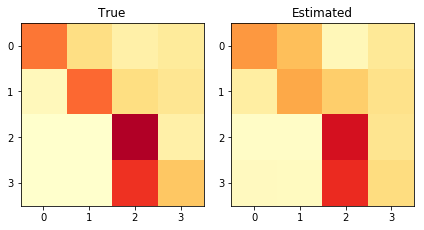

JS divergence: 0.0273	Norm Frobenius: 0.0743


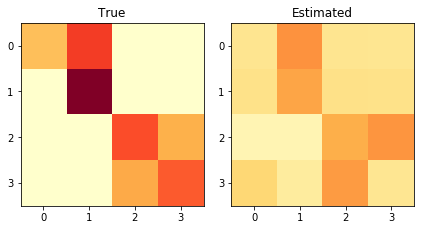

JS divergence: 0.2412	Norm Frobenius: 0.2398


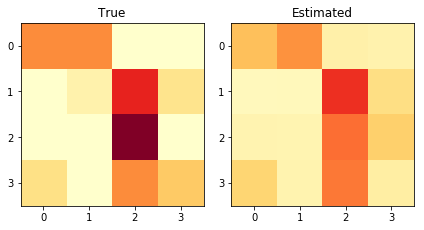

JS divergence: 0.1186	Norm Frobenius: 0.1543


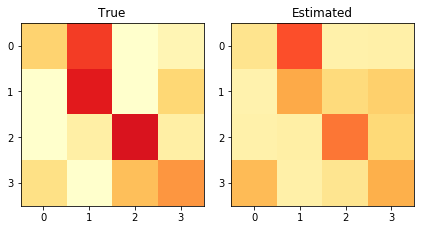

JS divergence: 0.1061	Norm Frobenius: 0.1477


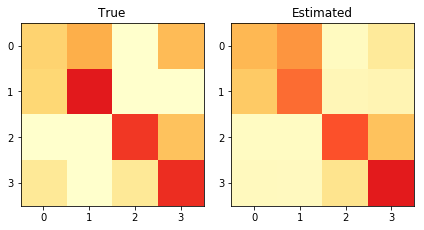

JS divergence: 0.0526	Norm Frobenius: 0.0884


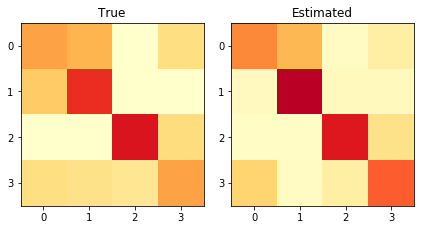

JS divergence: 0.0610	Norm Frobenius: 0.1066


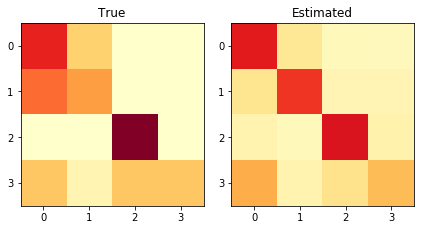

JS divergence: 0.0921	Norm Frobenius: 0.1448


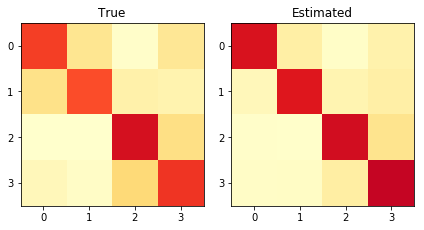

JS divergence: 0.0226	Norm Frobenius: 0.0813


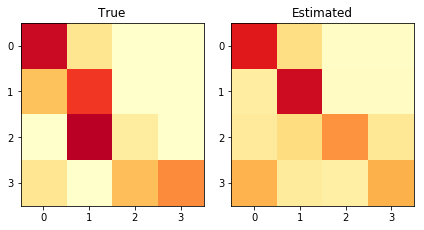

JS divergence: 0.1538	Norm Frobenius: 0.2223


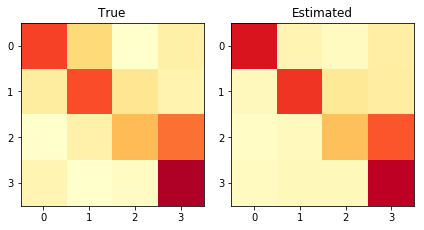

JS divergence: 0.0300	Norm Frobenius: 0.0643


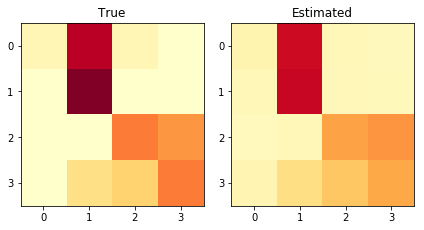

JS divergence: 0.0511	Norm Frobenius: 0.0697


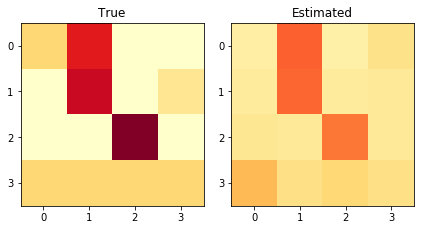

JS divergence: 0.1540	Norm Frobenius: 0.1747


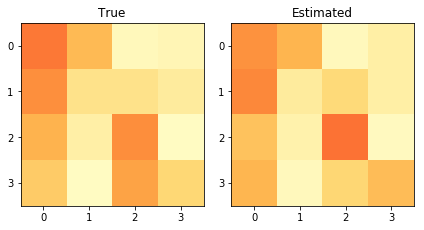

JS divergence: 0.0097	Norm Frobenius: 0.0606


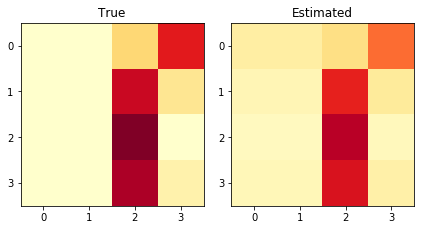

JS divergence: 0.0794	Norm Frobenius: 0.0884


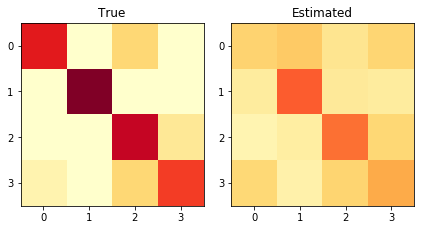

JS divergence: 0.2108	Norm Frobenius: 0.2292
Calculate confusion matrix on global version


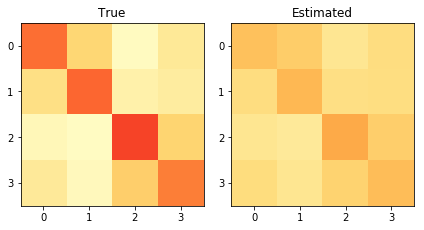

JS divergence: 0.0582	Norm Frobenius: 0.1367
A result


,,Accuracy,F1 (micro),F1 (macro),(R) NormF mean,(R) JS mean,(G) NormF,(G) JS
0,All,0.6467,0.6467,0.6301,0.1951,0.1603,0.1367,0.0582


Val
A result


,,Accuracy,F1 (micro),F1 (macro)
0,All,0.783,0.783,0.7412


Test
A result


,,Accuracy,F1 (micro),F1 (macro)
0,All,0.783,0.783,0.7412


In [44]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
prob_Yzt = raykarMC.get_confusionM()
#prob_Yxt = raykarMC.get_predictions_annot(Xstd_train,data=Z_train_p)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                    conf_true_G =confe_matrix_G, conf_pred_G = prob_Yzt.mean(axis=0))

#results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Val")
results2 = evaluate.calculate_metrics(Z=Z_val,Z_pred=Z_val_pred)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Ours Global multiples runs***
Train
Calculate confusion matrix on repeat version


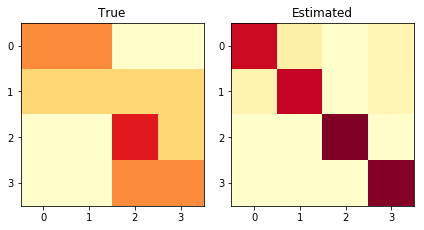

JS divergence: 0.2253	Norm Frobenius: 0.2913
Groups probabilities:  [1. 0. 0.]


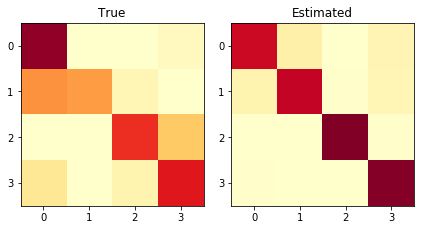

JS divergence: 0.1325	Norm Frobenius: 0.1962
Groups probabilities:  [1. 0. 0.]


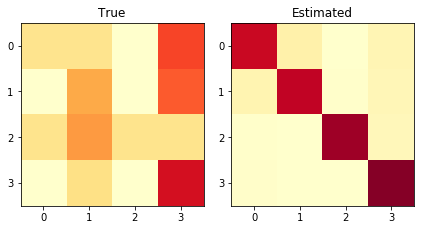

JS divergence: 0.3224	Norm Frobenius: 0.3688
Groups probabilities:  [0.9429 0.     0.0571]


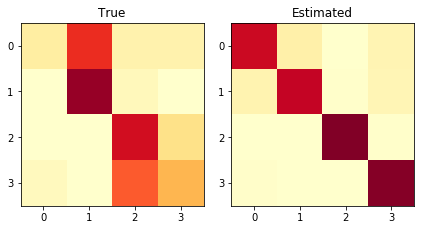

JS divergence: 0.2564	Norm Frobenius: 0.3281
Groups probabilities:  [1. 0. 0.]


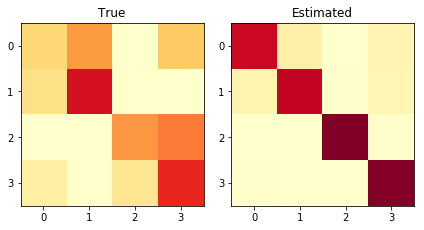

JS divergence: 0.1899	Norm Frobenius: 0.2729
Groups probabilities:  [1. 0. 0.]


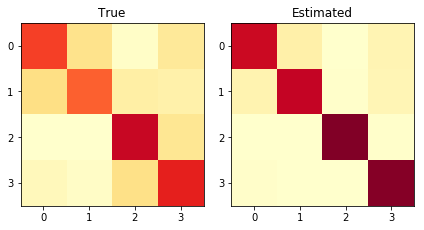

JS divergence: 0.0761	Norm Frobenius: 0.1346
Groups probabilities:  [1. 0. 0.]


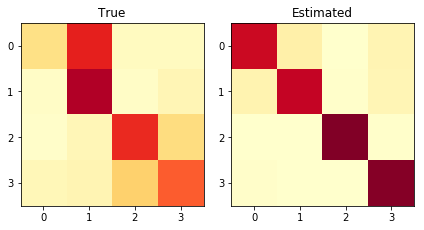

JS divergence: 0.1842	Norm Frobenius: 0.2705
Groups probabilities:  [1. 0. 0.]


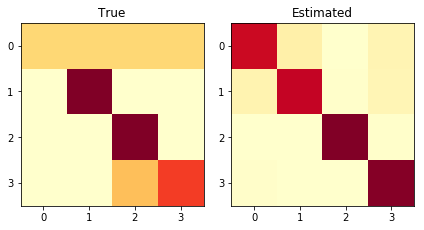

JS divergence: 0.1414	Norm Frobenius: 0.2081
Groups probabilities:  [9.999e-01 1.000e-04 0.000e+00]


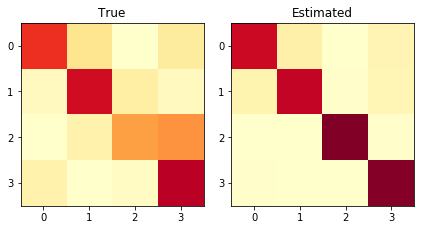

JS divergence: 0.1130	Norm Frobenius: 0.1942
Groups probabilities:  [1. 0. 0.]


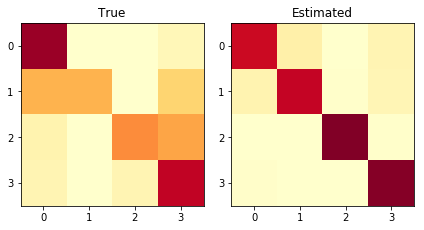

JS divergence: 0.1476	Norm Frobenius: 0.2270
Groups probabilities:  [1. 0. 0.]


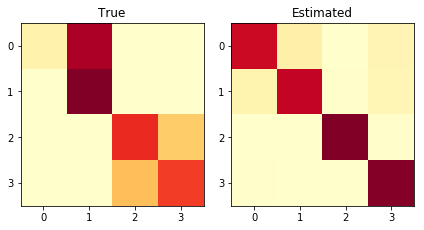

JS divergence: 0.2395	Norm Frobenius: 0.3164
Groups probabilities:  [1. 0. 0.]


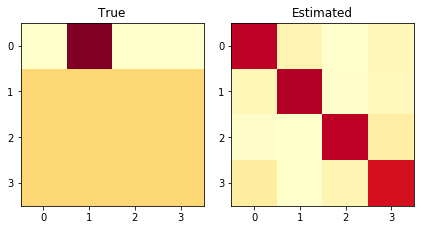

JS divergence: 0.4487	Norm Frobenius: 0.4407
Groups probabilities:  [0.6803 0.1943 0.1255]


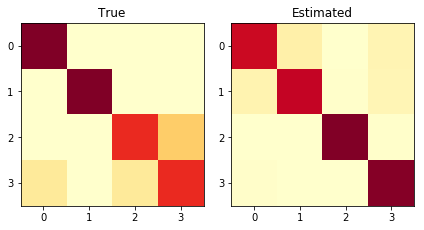

JS divergence: 0.1122	Norm Frobenius: 0.1476
Groups probabilities:  [1. 0. 0.]


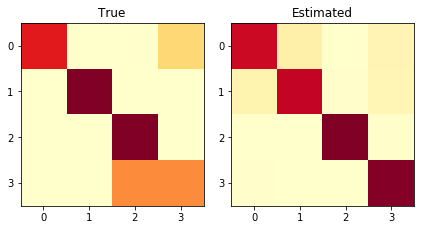

JS divergence: 0.1182	Norm Frobenius: 0.1879
Groups probabilities:  [9.997e-01 3.000e-04 0.000e+00]


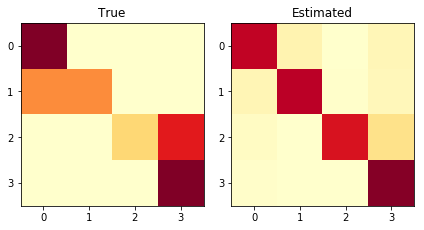

JS divergence: 0.1337	Norm Frobenius: 0.2461
Groups probabilities:  [0.7891 0.     0.2109]
Calculate confusion matrix on global version


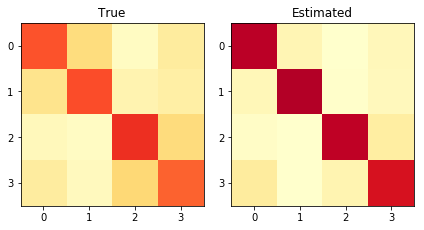

JS divergence: 0.0617	Norm Frobenius: 0.1392
A result


,,Accuracy,F1 (micro),F1 (macro),(R) NormF mean,(R) JS mean,(R) NormF w,(R) JS w,(G) NormF,(G) JS
0,All,0.6659,0.6659,0.6557,0.306,0.2642,0.2541,0.1944,0.1392,0.0617


Val


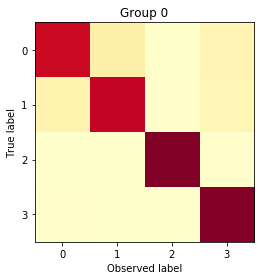

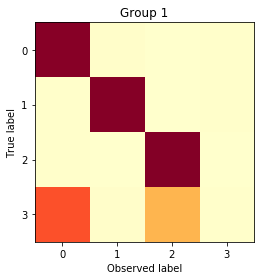

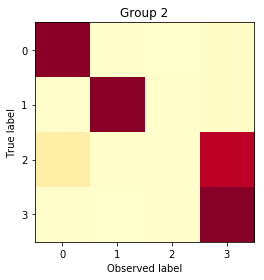

Inertia JS: 0.32555424069973066
Inertia NormF: 0.3633051593553451
A result


,Groups,Prob,T(g),Entropy,Diag mean,Isim (JS),S_raykar,S_bias,C_bias,Iner JS,Iner NormF,Accuracy,F1 (micro)
0,0,0.6689,910,0.3132,0.9142,0.9545,0.8856,0.0380,3,0.3256,0.3633,0.6588,0.6588
1,1,0.2002,272,0.2509,0.7411,0.7522,0.6548,0.1071,0,0.3256,0.3633,0.6160,0.6160
2,2,0.1309,178,0.2044,0.7364,0.7521,0.6485,0.2087,3,0.3256,0.3633,0.4644,0.4644


A result


,,Accuracy,F1 (micro),F1 (macro)
0,All,0.6625,0.6625,0.6484


In [166]:
evaluate = Evaluation_metrics(gMixture_Global,'our1') 
aux = gMixture_Global.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=False,p_z=Z_train_p)
predictions_m,prob_Gt,prob_Yzt,_ =  aux #to evaluate...
prob_Yz = gMixture_Global.calculate_Yz()
evaluate.set_Gt(prob_Gt)
print("*** Ours Global multiples runs***") #lambda = random

print("Train")
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     y_o=y_obs, y_o_groups=y_o_groups,# yo_pred=prob_Yxt,
                                    conf_true_G =confe_matrix_G, conf_pred_G = prob_Yz)

#results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Val")
c_M = gMixture_Global.get_confusionM()
y_o_groups = gMixture_Global.get_predictions_groups(Xstd_val,data=Z_val_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_val,Z_pred=Z_val_pred,conf_pred=c_M, y_o_groups=y_o_groups)

In [40]:
evaluate = Evaluation_metrics(gMixture_Global,'our1') 
aux = gMixture_Global.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True,p_z=Z_train_p)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
evaluate.set_Gt(prob_Gt)
print("*** Ours Global multiples runs***") #groups uniform...

print("Train")
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Global.get_confusionM()
y_o_groups = gMixture_Global.get_predictions_groups(Xstd_test,data=Z_test_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

NameError: name 'Evaluation_metrics' is not defined

*** Ours Individual1 multiples runs***
Train
Calculate confusion matrix on repeat version


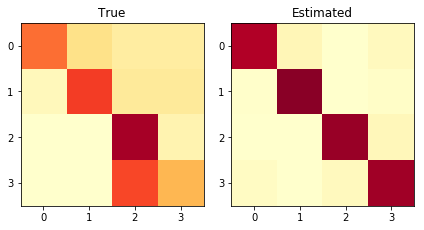

JS divergence: 0.1527	Norm Frobenius: 0.2469
Groups probabilities:  [0.8692 0.029  0.1017]


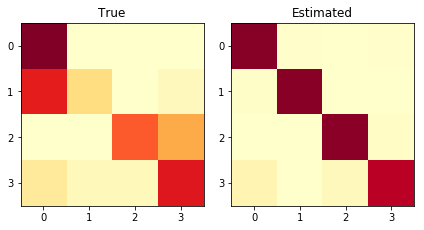

JS divergence: 0.1883	Norm Frobenius: 0.2971
Groups probabilities:  [0.8979 0.0886 0.0135]


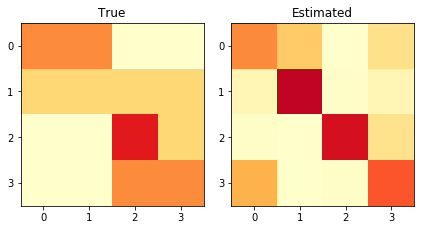

JS divergence: 0.2101	Norm Frobenius: 0.2462
Groups probabilities:  [0.0506 0.4395 0.5099]


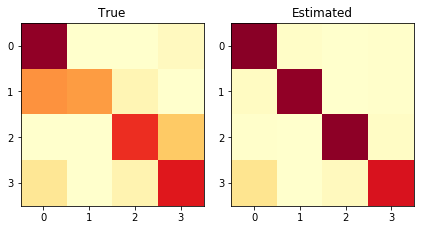

JS divergence: 0.1032	Norm Frobenius: 0.1979
Groups probabilities:  [0.7824 0.2013 0.0163]


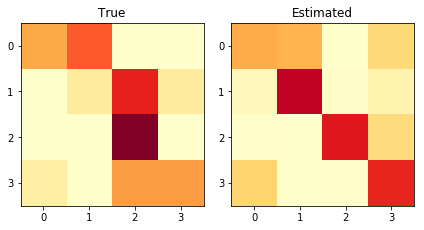

JS divergence: 0.2706	Norm Frobenius: 0.3131
Groups probabilities:  [0.0624 0.3071 0.6305]


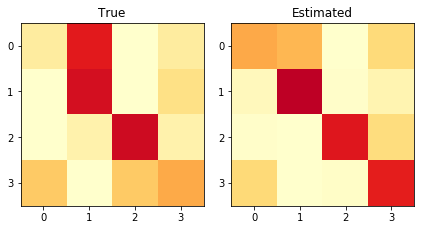

JS divergence: 0.0984	Norm Frobenius: 0.1758
Groups probabilities:  [0.0934 0.2881 0.6185]


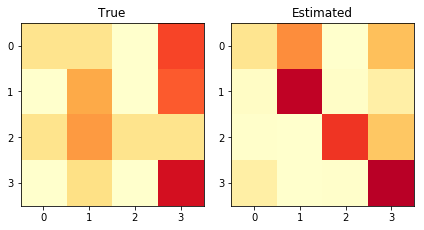

JS divergence: 0.2221	Norm Frobenius: 0.2769
Groups probabilities:  [0.0085 0.1313 0.8602]


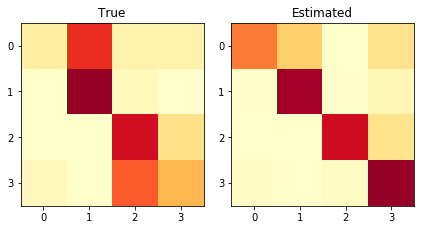

JS divergence: 0.1524	Norm Frobenius: 0.2572
Groups probabilities:  [0.4941 0.0247 0.4812]


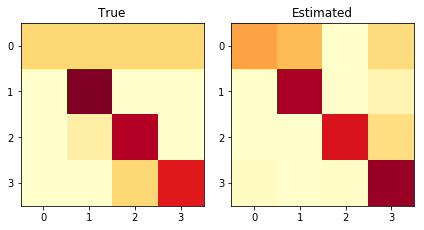

JS divergence: 0.1150	Norm Frobenius: 0.1322
Groups probabilities:  [0.369  0.0365 0.5945]


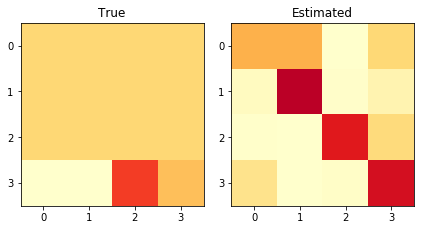

JS divergence: 0.3119	Norm Frobenius: 0.3234
Groups probabilities:  [0.1333 0.2187 0.648 ]


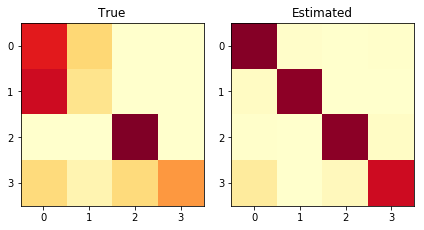

JS divergence: 0.2043	Norm Frobenius: 0.3106
Groups probabilities:  [0.8323 0.1579 0.0099]


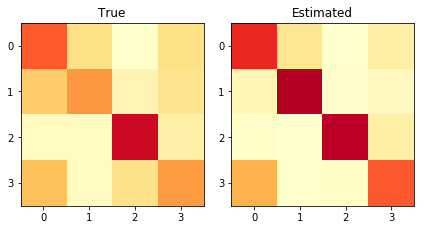

JS divergence: 0.0661	Norm Frobenius: 0.1441
Groups probabilities:  [0.2734 0.4362 0.2904]


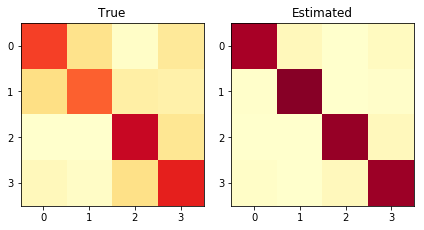

JS divergence: 0.0928	Norm Frobenius: 0.1597
Groups probabilities:  [0.9008 0.0171 0.082 ]


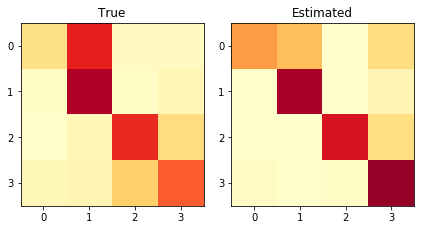

JS divergence: 0.0882	Norm Frobenius: 0.1700
Groups probabilities:  [0.3894 0.0323 0.5782]


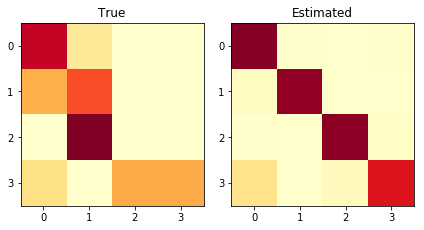

JS divergence: 0.3428	Norm Frobenius: 0.3935
Groups probabilities:  [0.7726 0.2153 0.0121]
Calculate confusion matrix on global version


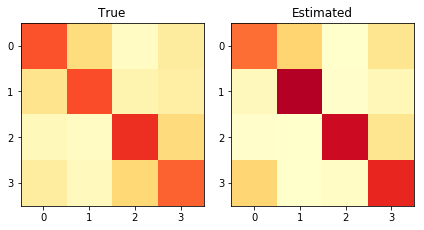

JS divergence: 0.0596	Norm Frobenius: 0.1143
A result


,,Accuracy,F1 (micro),F1 (macro),(R) NormF mean,(R) JS mean,(G) NormF,(G) JS
0,All,0.6855,0.6855,0.6642,0.2786,0.2397,0.1143,0.0596


Val


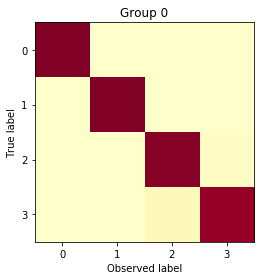

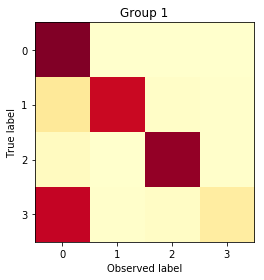

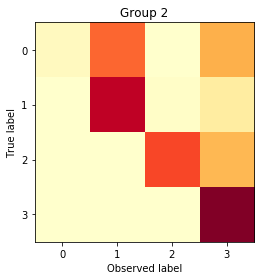

Inertia JS: 0.31377889128227826
Inertia NormF: 0.3553775649822834
A result


,Groups,Prob,Entropy,Diag mean,Isim (JS),S_raykar,S_bias,C_bias,Iner JS,Iner NormF,Accuracy,F1 (micro)
0,0,0.2420,0.0899,0.9809,0.9903,0.9745,0.0076,2,0.3138,0.3554,0.6574,0.6574
1,1,0.3035,0.3126,0.7281,0.7923,0.6375,0.2767,0,0.3138,0.3554,0.6115,0.6115
2,2,0.4544,0.4932,0.6349,0.7092,0.5132,0.2003,3,0.3138,0.3554,0.4614,0.4614


A result


,,Accuracy,F1 (micro),F1 (macro)
0,All,0.661,0.661,0.6373


In [172]:
evaluate = Evaluation_metrics(gMixture_Ind1,'our1') 
aux = gMixture_Ind1.calculate_extra_components(Xstd_train, A,calculate_pred_annotator=False,p_z=Z_train_p,p_g=prob_Gt)
predictions_m,prob_Gt,prob_Yzt,_ =  aux #to evaluate...
prob_Yz = gMixture_Ind1.calculate_Yz(prob_Gt)
evaluate.set_Gt(prob_Gt)
print("*** Ours Individual1 multiples runs***") #lambda = 1

print("Train")
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                    conf_true_G =confe_matrix_G, conf_pred_G = prob_Yz)


print("Val")
c_M = gMixture_Ind1.get_confusionM()
y_o_groups = gMixture_Global.get_predictions_groups(Xstd_val,data=Z_val_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_val,Z_pred=Z_val_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours Individual3 multiples runs***
Train
Calculate confusion matrix on repeat version


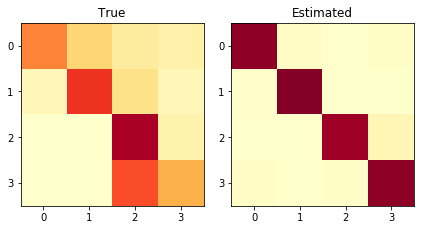

JS divergence: 0.1910	Norm Frobenius: 0.2673
Groups probabilities:  [0.0336 0.     0.9664]


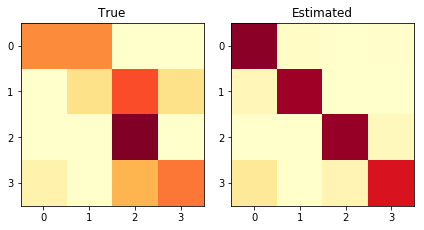

JS divergence: 0.2512	Norm Frobenius: 0.3154
Groups probabilities:  [0.2841 0.     0.7159]


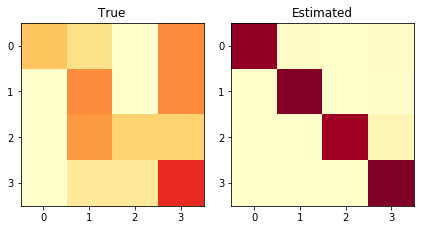

JS divergence: 0.3069	Norm Frobenius: 0.3502
Groups probabilities:  [5.000e-04 4.900e-03 9.947e-01]


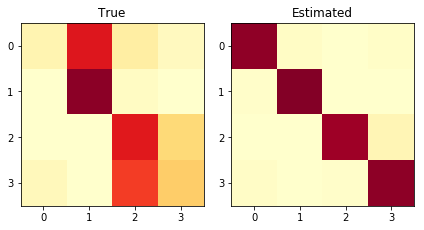

JS divergence: 0.3044	Norm Frobenius: 0.3812
Groups probabilities:  [0.0312 0.     0.9688]


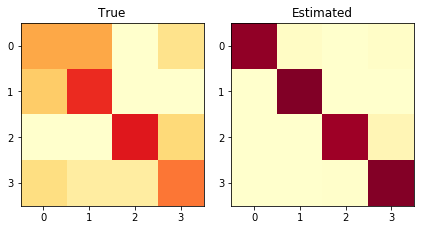

JS divergence: 0.1874	Norm Frobenius: 0.2483
Groups probabilities:  [0.0025 0.     0.9975]


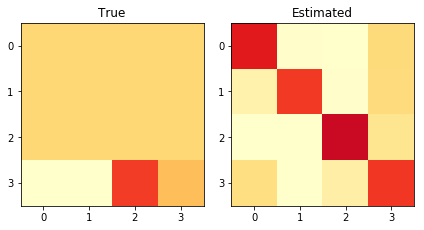

JS divergence: 0.2985	Norm Frobenius: 0.3139
Groups probabilities:  [0.4223 0.2375 0.3402]


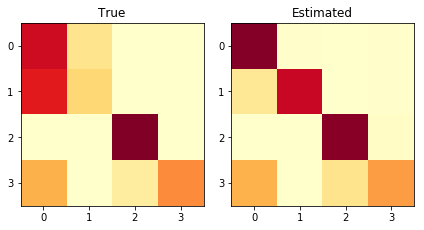

JS divergence: 0.0939	Norm Frobenius: 0.2187
Groups probabilities:  [0.7415 0.     0.2585]


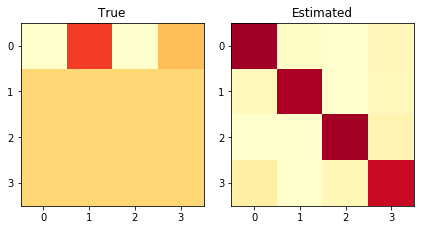

JS divergence: 0.4834	Norm Frobenius: 0.4331
Groups probabilities:  [0.2203 0.0434 0.7363]


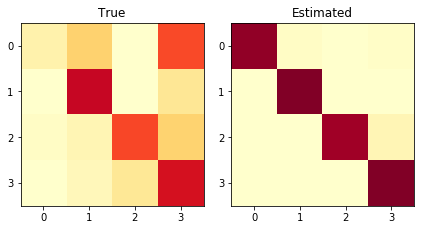

JS divergence: 0.2398	Norm Frobenius: 0.3018
Groups probabilities:  [0. 0. 1.]


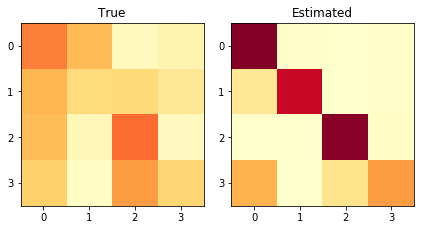

JS divergence: 0.2242	Norm Frobenius: 0.2777
Groups probabilities:  [0.7346 0.     0.2654]


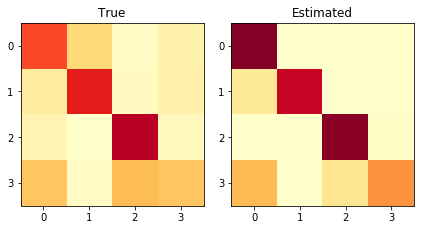

JS divergence: 0.0762	Norm Frobenius: 0.1324
Groups probabilities:  [0.6917 0.     0.3083]


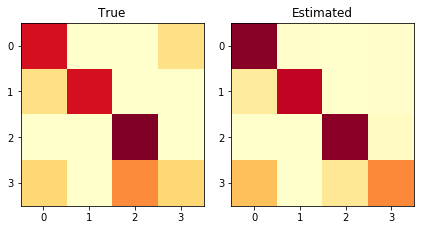

JS divergence: 0.0555	Norm Frobenius: 0.1298
Groups probabilities:  [0.6502 0.     0.3498]


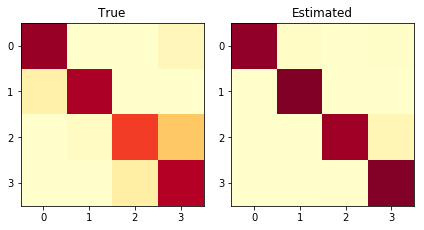

JS divergence: 0.0507	Norm Frobenius: 0.1033
Groups probabilities:  [0.0026 0.     0.9974]


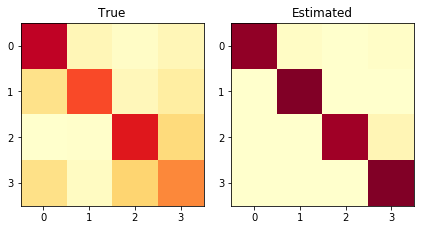

JS divergence: 0.1373	Norm Frobenius: 0.1927
Groups probabilities:  [0. 0. 1.]


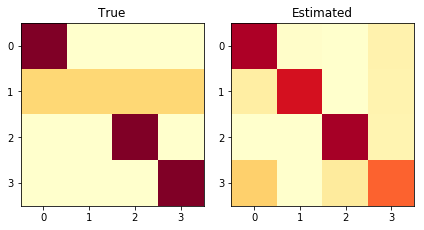

JS divergence: 0.1528	Norm Frobenius: 0.2099
Groups probabilities:  [0.5519 0.0827 0.3653]
Calculate confusion matrix on global version


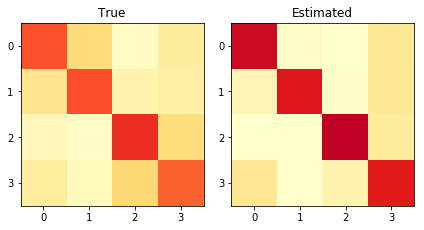

JS divergence: 0.0658	Norm Frobenius: 0.1189
A result


,,Accuracy,F1 (micro),F1 (macro),(R) NormF mean,(R) JS mean,(G) NormF,(G) JS
0,All,0.6877,0.6877,0.6762,0.2909,0.2554,0.1189,0.0658


Val


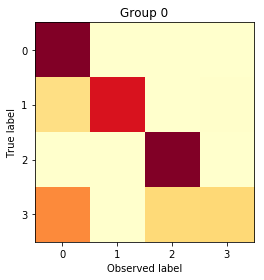

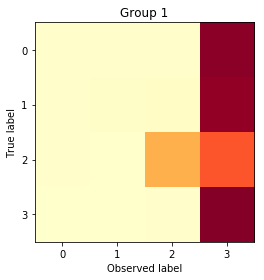

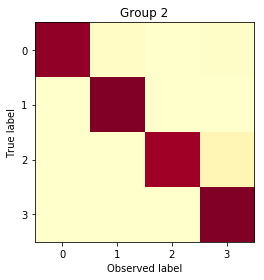

Inertia JS: 0.46039892536607957
Inertia NormF: 0.44236856900251925
A result


,Groups,Prob,Entropy,Diag mean,Isim (JS),S_raykar,S_bias,C_bias,Iner JS,Iner NormF,Accuracy,F1 (micro)
0,0,0.3282,0.4233,0.7553,0.8317,0.6737,0.1740,0,0.4604,0.4424,0.6021,0.6021
1,1,0.1609,0.2849,0.3481,0.4185,0.1308,0.8284,3,0.4604,0.4424,0.6072,0.6072
2,2,0.5109,0.1269,0.9718,0.9856,0.9624,0.0193,3,0.4604,0.4424,0.6074,0.6074


A result


,,Accuracy,F1 (micro),F1 (macro)
0,All,0.6068,0.6068,0.5942


In [47]:
evaluate = Evaluation_metrics(gMixture_Ind3,'our1') 
aux = gMixture_Ind3.calculate_extra_components(Xstd_train, A,calculate_pred_annotator=False,p_z=Z_train_p,p_g=prob_Gt)
predictions_m,prob_Gt,prob_Yzt,_ =  aux #to evaluate...
prob_Yz = gMixture_Ind3.calculate_Yz(prob_Gt)
evaluate.set_Gt(prob_Gt)
print("*** Ours Individual3 multiples runs***") #lambda = 1

print("Train")
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                    conf_true_G =confe_matrix_G, conf_pred_G = prob_Yz)


print("Val")
c_M = gMixture_Ind3.get_confusionM()
y_o_groups = gMixture_Global.get_predictions_groups(Xstd_val,data=Z_val_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_val,Z_pred=Z_val_pred,conf_pred=c_M, y_o_groups=y_o_groups)

In [43]:
plot_alphas(gMixture_Ind1.alphas_training)

NameError: name 'plot_alphas' is not defined

In [44]:
plot_alphas(gMixture_Ind3.alphas_training)

NameError: name 'plot_alphas' is not defined

### project confusion matrices

In [42]:
def flatten_conf(m):
    return m.reshape(m.shape[0], np.prod(m.shape[1:]))

to_plot = flatten_conf(confe_matrix_R)

centroids_plot_G = flatten_conf(gMixture_Global.get_confusionM())
centroids_plot_IT = flatten_conf(gMixture_Ind1.get_confusionM())
centroids_plot_IK = flatten_conf(gMixture_Ind3.get_confusionM())
global_plot = (confe_matrix_G.flatten()).reshape(1,-1)

from sklearn.decomposition import PCA
model = PCA(2)
model.fit(to_plot) 

to_plot = model.transform(to_plot) 
centroids_plot_G = model.transform(centroids_plot_G)
centroids_plot_IT = model.transform(centroids_plot_IT)
centroids_plot_IK = model.transform(centroids_plot_IK)
global_plot = model.transform(global_plot)

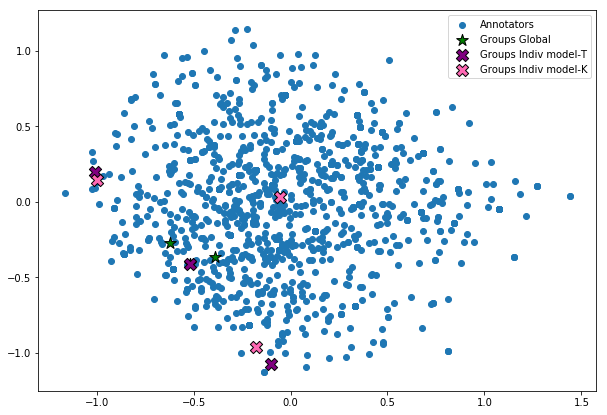

In [43]:
plt.figure(figsize=(10,7))
plt.scatter(to_plot[:,0], to_plot[:,1], label="Annotators")
plt.scatter(centroids_plot_G[:,0], centroids_plot_G[:,1], s=150,marker="*", color='g',label="Groups Global", edgecolor='black')
plt.scatter(centroids_plot_IT[:,0], centroids_plot_IT[:,1],s=150, marker="X", color='purple',label="Groups Indiv model-T", edgecolor='black')
plt.scatter(centroids_plot_IK[:,0], centroids_plot_IK[:,1], s=150, marker="X", color='hotpink',label="Groups Indiv model-K", edgecolor='black')
#plt.scatter(global_plot[:,0], global_plot[:,1],label="Global")

plt.legend()
plt.show()#nuevo